
# <center><a class="tocSkip"></center>
# <center>MGMT474 Predictive Analytics</center>
# <center>Time Series </center>    
# <center>Professor: Davi Moreira </center>



<hr>

<center>
<div>
<img src="https://raw.githubusercontent.com/davi-moreira/2025F_predictive_analytics_purdue_MGMT474/main/images/mgmt_474_ai_logo_02-modified.png" width="200"/>
</div>
</center>

This lecture material was developed with reference to [*Forecasting: Principles and Practice, the Pythonic Way*](https://otexts.com/fpppy/), [`sktime` documentation](https://www.sktime.net/en/v0.20.0/users.html), [*Time Series Analysis with Python* Book](https://filippomb.github.io/python-time-series-handbook/notebooks/00/intro.html), [`scikit-learn` documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data), and customized for our course-specific learning objectives. You are welcome to use, share, and expand upon this material.

If you want to review the Time Series topic we covered in our Business Statistics course, [here you can access the lecture slides](https://davi-moreira.github.io/2025S_business_statistics_purdue_MGMT305/lecture_slides/17_chapter_time_series/17_chapter_time_series.html#/title-slide).

**Have fun!**


# Overview

- core distinctions between *forecasting* and *generic supervised prediction*.



## Learning Objectives

- Differentiate **forecasting** from **generic supervised prediction**.  
- Specify correct **evaluation protocols** for time series.  


# 1 - Forecasting vs. Generic Supervised Prediction


## Problem Framing: Two Worlds

### Generic Supervised Prediction

- Predict a target from feature columns.
- Rows assumed **exchangeable**; order irrelevant.
- Standard random/stratified splits.
- Examples: tabular regression, classification.

### Forecasting

- Predict **future rows** of the same variable from **past rows**.
- **Temporal order is intrinsic**; rows are not exchangeable.
- Time-aware splits and backtesting required.
- Examples: demand, traffic, finance, sensor data.


## Why We Get Confused

Both output numeric or categorical predictions, but **data-generating processes differ**.  

Treating forecasting as generic regression **ignores time order** and **future-unknown constraints**.  

This changes **feature construction**, **model interfaces**, and **evaluation**.


## Evaluation Protocols

### Generic Regression

- Random/stratified splits commonly used.
- K-fold CV with row shuffling is acceptable.

### Forecasting

- **Temporal train/test split** (hold-out *by time*).  

- **Rolling/expanding backtests** across cutpoints/horizons.  

- Random splits cause **information leakage** and **over-optimistic scores**.


## Common Pitfalls

- **Row shuffling** in time series evaluation.  

- **Ad-hoc lagging/windowing** with hidden hyperparameters.  

- Producing repeated **nowcasts** instead of true **multi-step forecasts**.  

- Failing to map predictions back to a **properly indexed horizon**.


# 2 - Time Series Graphics

<br>
<br>


> Source: Chapter 2 “Time series graphics” (FPP, Pythonic Way).  
> URL: https://otexts.com/fpppy/nbs/02-graphics.html

## Load common libraries and settings

In [1]:
!pip -q install utilsforecast statsmodels seaborn matplotlib cycler

In [2]:
!pip install fpppy

In [3]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
# mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

# Then, once anywhere before plotting:
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.rcParamsDefault['axes.prop_cycle']

from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
import matplotlib as mpl
# Restore the default Tableau 10 cycle
mpl.rcParams['axes.prop_cycle'] = mpl.rcParamsDefault['axes.prop_cycle']


## Introduction

In any data analysis workflow, **the first step is EDA with visualization**. Plotting the data reveals critical insights such as:

* **Patterns and trends** across time
* **Outliers and anomalies** that may distort interpretation
* **Structural changes** and seasonality in time-dependent data
* **Relationships** among variables

These visual features guide the **choice and specification of forecasting models**. Effective forecasting depends on understanding what the data reveal through visualization.



## Time Series Plots

For time series data, the **most fundamental visualization** is the **time plot**.

In a time plot, each observation is displayed against its corresponding time point, and **consecutive observations are connected by straight lines** to reveal patterns, trends, or irregularities over time.

This type of graph enables analysts to identify:

* Long-term trends
* Seasonal fluctuations
* Sudden shifts or anomalies

For example, a time plot of **weekly economy passenger load** between **Melbourne and Sydney** illustrates how air travel demand evolves through time.


### Ansett airlines economy class: Melbourne-Sydney

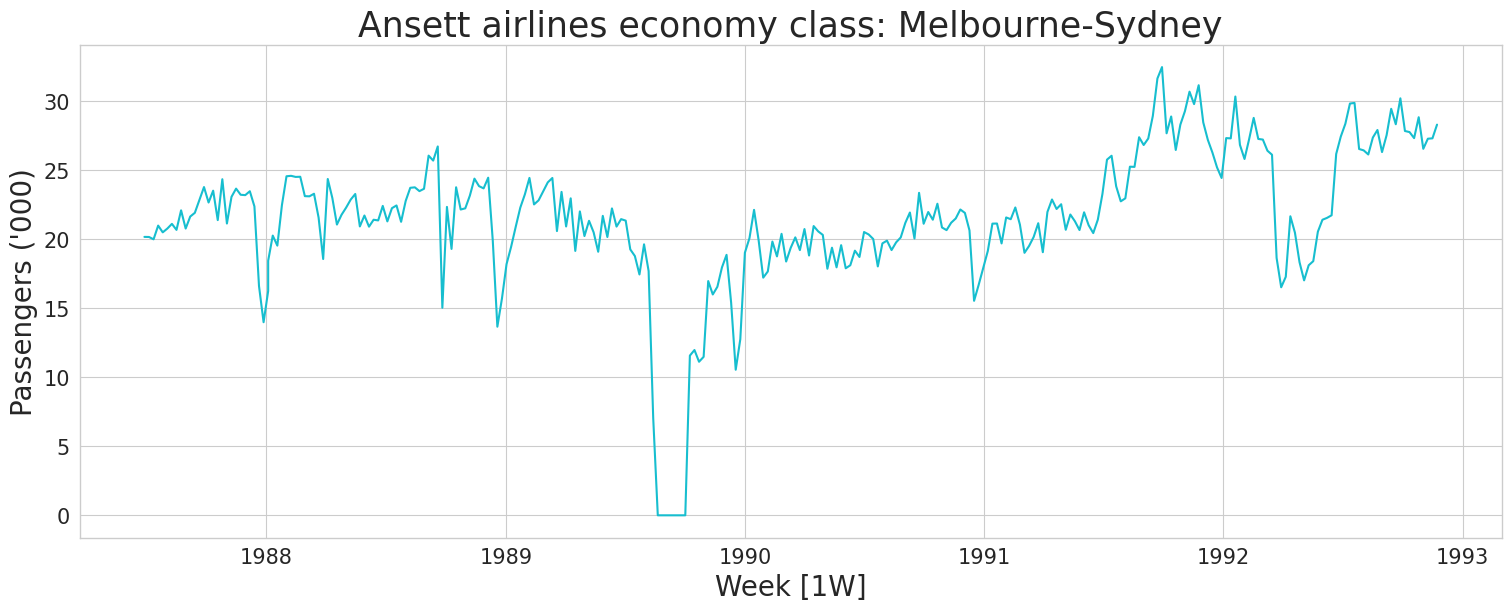

In [5]:
ansett = pd.read_csv("ansett.csv")
ansett["ds"] = pd.to_datetime(ansett["ds"])
melsyd_economy = ansett.query('Airports == "MEL-SYD" & Class == "Economy"').copy()
melsyd_economy["y"] = melsyd_economy["y"] / 1000
sns.set_style("whitegrid")
plot_series(df=melsyd_economy,
            id_col="Airports",
            time_col="ds",
            target_col="y",
            ylabel="Passengers ('000)",
            xlabel="Week [1W]",
            title="Ansett airlines economy class: Melbourne-Sydney")

### Ansett airlines economy class: Melbourne-Sydney

This plot reveals some interesting features.

- There was a period in 1989 when no passengers were carried — this was due to an industrial dispute.

- There was a period of reduced load in 1992. This was due to a trial in which some economy class seats were replaced by business class seats.

- A large increase in passenger load occurred in the second half of 1991.

- There are some large dips in load around the start of each year. These are due to holiday effects.

- There is a long-term fluctuation in the level of the series which increases during 1987, decreases in 1989, and increases again through 1990 and 1991.

Any model will need to take all these features into account in order to effectively forecast the passenger load into the future.


### Australian antidiabetic drug sales

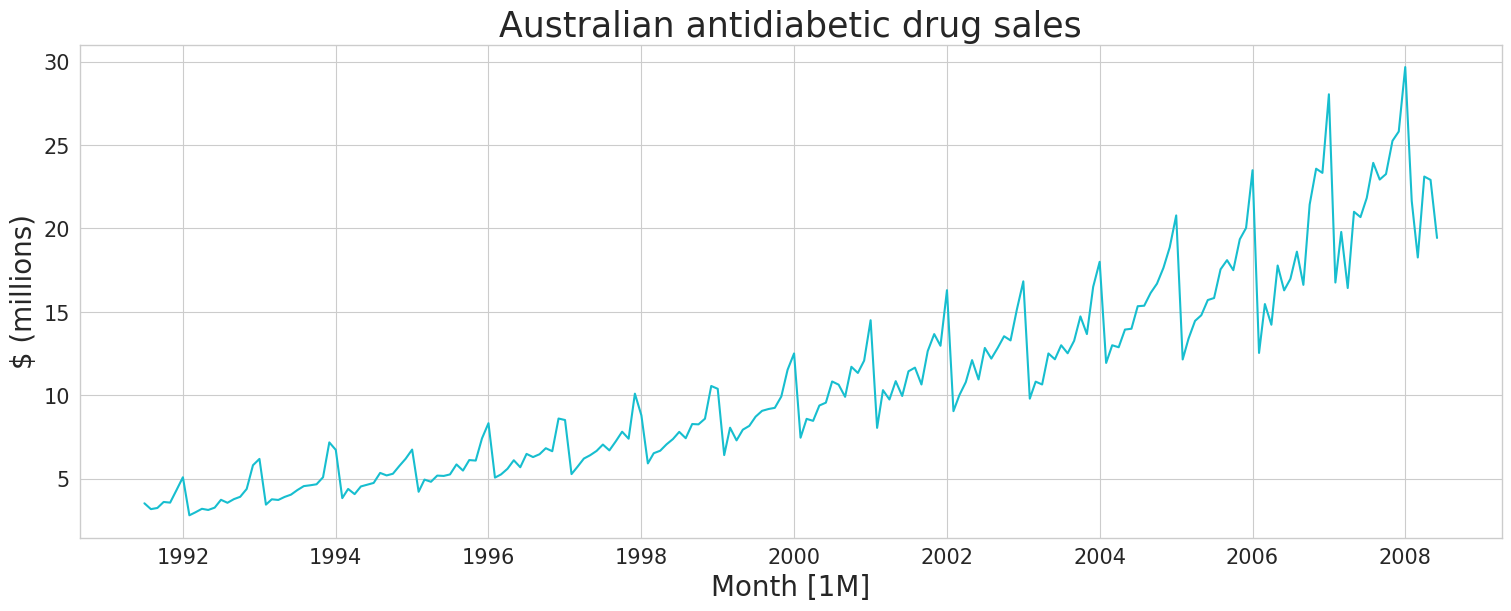

In [6]:
total_cost_df = pd.read_csv("total_cost_df.csv", parse_dates=["Month"])
total_cost_df["unique_id"] = "total_cost"

sns.set_style("whitegrid")
plot_series(total_cost_df,
            id_col="unique_id",
            time_col="Month",
            target_col="Cost",
            xlabel="Month [1M]",
            ylabel="$ (millions)",
            title="Australian antidiabetic drug sales")

### Australian antidiabetic drug sales

This example shows a **clear upward trend** combined with a **strong seasonal component** whose amplitude increases with the overall level of the series.

A **sharp drop at the beginning of each year** results from a government **subsidisation policy**, which encourages patients to **stockpile medications** before year-end.

When forecasting such data, the model must capture:

* The **seasonal pattern** and its **changing magnitude**
* The **gradual evolution of the trend** over time


# 3 - Time Series Patterns

When analyzing time series data, we frequently refer to **trend**, **seasonal**, and **cyclic** components. These concepts define the underlying structure of temporal behavior.



## **Trend**

A **trend** represents a long-term increase or decrease in the data.

* It may be **linear or nonlinear**.
* A trend can **change direction**, shifting from growth to decline or vice versa.
* Example: The **antidiabetic drug sales** (Figure 2.2) show a steady upward trend.



## **Seasonal**

A **seasonal pattern** arises from **systematic calendar-based effects** such as:

* Time of year
* Day of week
* Hour of day

Seasonality has a **fixed and known period**, and a series can exhibit **multiple seasonalities** (e.g., yearly and weekly).
Example: The **monthly antidiabetic drug sales** display seasonality influenced by **year-end cost changes**.



## **Cyclic**

A **cycle** involves **rises and falls with no fixed frequency**, often linked to **economic conditions** such as the **business cycle**.

* Cycles usually last **two years or more**.
* The **magnitude and duration** of cycles are **less regular** than seasonal patterns.



## **Key Distinction**

- If fluctuations occur at a **fixed, calendar-based frequency**, they are **seasonal**.

- If they occur at a **variable frequency**, they are **cyclic**.

## **Practical Insight**

Most real-world time series combine **trend**, **seasonal**, and **cyclic** components.

When selecting a forecasting model, it is essential to first **identify these patterns** and then apply a method capable of **capturing their combined effects**.



## Four examples of time series showing different patterns

<center>
<div>
<img src="https://raw.githubusercontent.com/davi-moreira/2025F_predictive_analytics_purdue_MGMT474/main/lecture_slides/08_time_series/figs/fourexamples-output-1.png" width="1000"/>
</div>
</center>

## Four Examples of Time Series Showing Different Patterns

1. **Monthly Housing Sales (Top Left)**

   * Exhibit **strong seasonality** within each year.
   * Display **cyclic behavior** with a period of approximately **6–10 years**.
   * Show **no clear long-term trend** over the observed period.

2. **US Treasury Bill Contracts (Top Right)**

   * Reflect data from the **Chicago market** over **100 trading days in 1981**.
   * Show **no seasonality**, but a **clear downward trend**.
   * With a longer horizon, this trend could represent part of a **larger economic cycle**.

3. **Australian Quarterly Electricity Production (Bottom Left)**

   * Demonstrates a **strong upward trend** coupled with **pronounced seasonality**.
   * **No visible cyclic pattern**, suggesting stable periodicity tied to seasonal factors.

4. **Daily Change in Google Closing Stock Price (Bottom Right)**

   * Displays **no trend**, **no seasonality**, and **no cyclic behavior**.
   * Characterized by **random fluctuations**, lacking predictable patterns suitable for traditional forecasting.


## Lag plots


### Lagged scatterplots for quarterly beer production.

/tmp/ipython-input-87298660.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


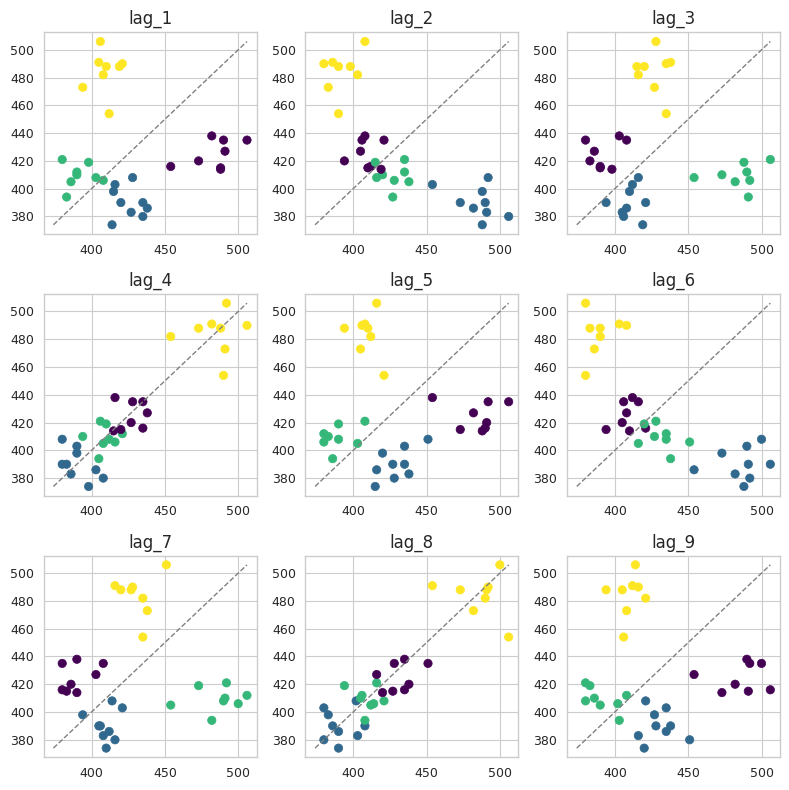

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read and parse dates
aus_production = pd.read_csv("aus_production.csv", parse_dates=["ds"])

# 2) Filter by calendar year (not by string/int compare)
recent_production = (
    aus_production.loc[aus_production["ds"].dt.year >= 2000, ["ds", "Beer"]]
    .rename(columns={"Beer": "y"})
    .copy()
)

# 3) Time-derived fields
recent_production["Quarter"] = recent_production["ds"].dt.quarter

# 4) Build lags
for lag in range(1, 10):
    recent_production[f"lag_{lag}"] = recent_production["y"].shift(lag)

lags = [f"lag_{i}" for i in range(1, 10)]

# 5) Drop rows with NaNs (from shifting) for plotting and limits
plot_df = recent_production[["y", "Quarter", *lags]].dropna()

# 6) Limits ignoring NaNs
lims = [
    np.nanmin([plot_df[lag].min() for lag in lags] + [plot_df["y"].min()]),
    np.nanmax([plot_df[lag].max() for lag in lags] + [plot_df["y"].max()]),
]

# 7) Lag plots
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax, lag in zip(axes.flatten(), lags):
    ax.scatter(plot_df[lag], plot_df["y"], c=plot_df["Quarter"], cmap="viridis")
    ax.plot(lims, lims, "grey", linestyle="--", linewidth=1)
    ax.set_title(lag)
plt.tight_layout()
plt.show()


### Lagged Scatterplots for Quarterly Beer Production

This plot presents **scatterplots of quarterly Australian beer production**, where the **horizontal axis** represents **lagged values** of the series.

Each graph displays **$y_t$ plotted against $y_{t-k}$** for various lag values $k$.

* **Color coding** indicates the **quarter** corresponding to the observation on the vertical axis.
* A **strong positive relationship** appears at **lags 4 and 8**, revealing the **seasonal pattern** that repeats annually.
* **Negative relationships** at **lags 2 and 6** occur because **peaks (Q4)** are compared with **troughs (Q2)**, emphasizing the alternation between seasonal highs and lows.


## Autocorrelation

**Autocorrelation** quantifies the **linear relationship between lagged observations** of the same time series, analogous to how standard correlation measures relationships between two different variables.

For each lag $k$, there is an **autocorrelation coefficient** $r_k$:

* $r_1$ measures the relationship between $y_t$ and $y_{t-1}$
* $r_2$ measures the relationship between $y_t$ and $y_{t-2}$
* and so on

The general formula for the $k$-th autocorrelation is:

$$
r_k ;=;
\frac{\displaystyle \sum_{t=k+1}^{T} (y_t-\bar{y})(y_{t-k}-\bar{y})}
{\displaystyle \sum_{t=1}^{T} (y_t-\bar{y})^2},
$$

where $T$ denotes the length of the time series.

The complete set of autocorrelation coefficients forms the **Autocorrelation Function (ACF)**, which summarizes how current values relate to past values across different lags.

For instance, in the **beer production dataset**, the ACF can be computed directly using the `acf()` function.


In [8]:
acf_df = pd.DataFrame(
    {"Lag": range(10), "ACF": sm.tsa.acf(recent_production["y"].dropna(), nlags=9,
        fft=False, bartlett_confint=False)}
).set_index("Lag")
acf_df[1:]

,ACF
Lag,
1,-0.053
2,-0.758
3,-0.026
4,0.802
5,-0.077
6,-0.657
7,0.001
8,0.707
9,-0.089


The values in the `ACF` column are $r_1, \ldots, r_9$, corresponding to the nine scatterplots in Figure 2.19. We usually plot the ACF to see how the correlations change with the lag $k$. The plot is sometimes known as a *correlogram*.


### Autocorrelation function for quarterly beer production.

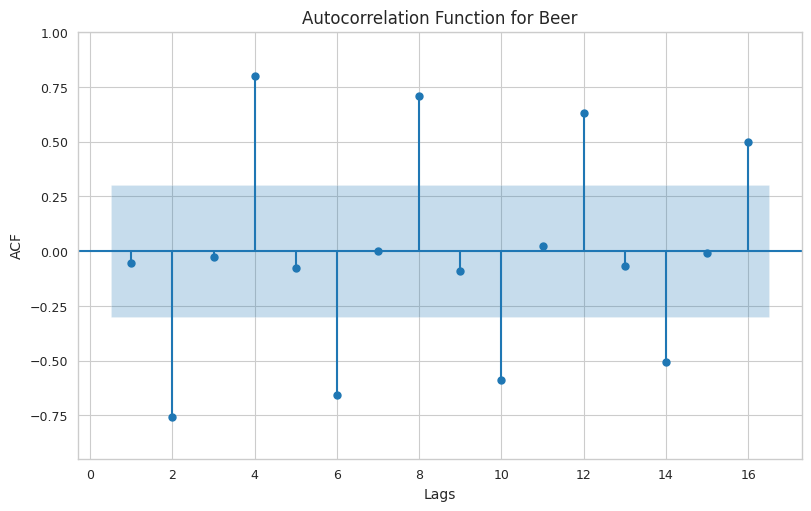

In [9]:
fig, ax = plt.subplots()
sns.set_style("whitegrid")
plot_acf(recent_production["y"].dropna(), lags=16, ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True)
ax.set_title("Autocorrelation Function for Beer")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")
plt.show()

### Autocorrelation function for quarterly beer production.

- $r_4$ is higher than for the other lags. This is due to the seasonal pattern in the data: the peaks tend to be four quarters apart and the troughs tend to be four quarters apart.

- $r_2$ is more negative than for the other lags because troughs tend to be two quarters behind peaks.

- The grey area indicate whether the correlations are significantly different from zero (as explained in Section 2.9).



### Trend and Seasonality in ACF Plots

The **Autocorrelation Function (ACF)** reveals distinct patterns that help identify **trend** and **seasonality** in time series data.

* **Trend Effect:**

  When a series exhibits a trend, **nearby observations** in time are also **close in value**.
  Consequently, **autocorrelations for small lags** are **large and positive**, and they **decline gradually** as the lag increases.

* **Seasonality Effect:**

  When a series is seasonal, **autocorrelations spike** at **multiples of the seasonal period** (e.g., lags 4, 8, 12 for quarterly data).

* **Combined Effect:**

  When both **trend and seasonality** are present, the ACF displays a **slow decay** due to the trend and a **scalloped or wavelike pattern** due to seasonality.



### Autocorrelation function for monthly antidiabetic drug sales in Australia

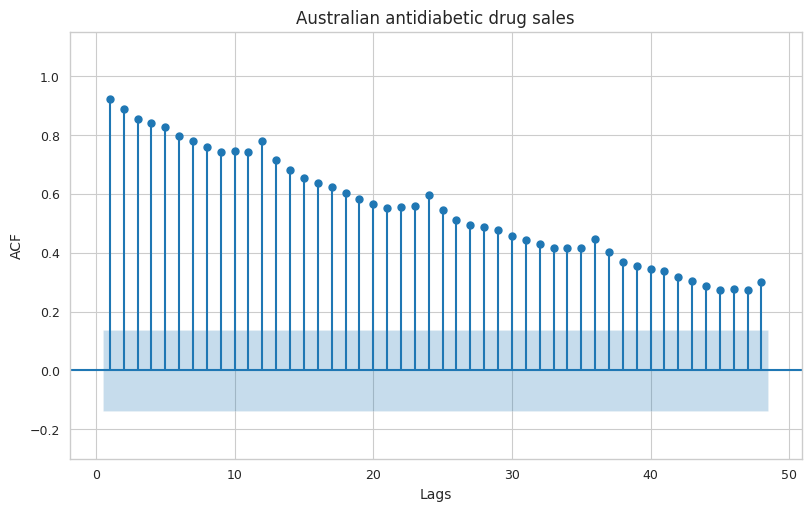

In [10]:
total_cost_df = pd.read_csv("total_cost_df.csv", parse_dates=["Month"])
fig, ax = plt.subplots()
sns.set_style("whitegrid")
plot_acf(total_cost_df["Cost"], lags=48, ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True)
ax.set_title("Australian antidiabetic drug sales")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")
ax.set_ylim(bottom=-0.3)
plt.show()

### Autocorrelation function for monthly antidiabetic drug sales in Australia

- The **slow decline** in autocorrelation reflects the **trend**

- The **repeating scalloped shape** indicates **seasonal periodicity**.


## White noise

Time series that show no autocorrelation are called white noise.

### White noise series

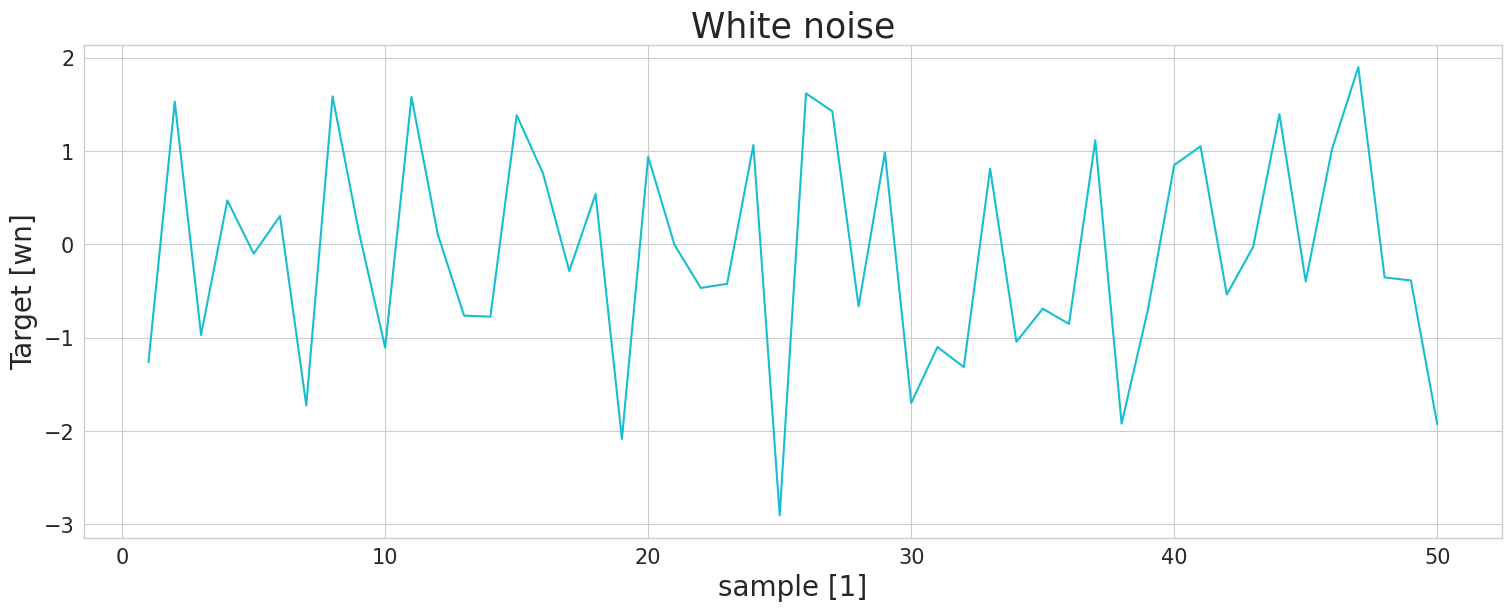

In [11]:
np.random.seed(30)
y = pd.DataFrame({"wn": np.random.normal(0, 1, 50), "ds": np.arange(1, 51)})
y["unique_id"] = "wn"
sns.set_style("whitegrid")
plot_series(y, target_col="wn", xlabel="sample [1]", title="White noise")

### Autocorrelation function for the white noise series

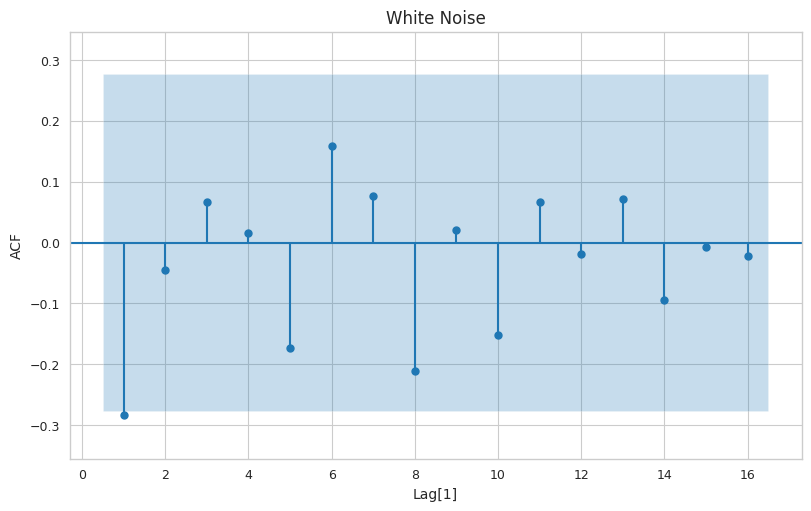

In [12]:
fig, ax = plt.subplots()
sns.set_style("whitegrid")
plot_acf(y["wn"], lags=16, ax=ax, zero=False, bartlett_confint=False, auto_ylims=True)
ax.set_title("White Noise")
ax.set_xlabel("Lag[1]")
ax.set_ylabel("ACF")
plt.show()

### Autocorrelation Function for the White Noise Series

In a **white noise series**, each observation is **independent and identically distributed**, meaning there is **no predictable pattern or correlation** across time.

* The **autocorrelations** are expected to be **close to zero**, though not exactly zero due to random variation.
* For such a series, approximately **95% of ACF spikes** should lie within the bounds, $\pm \frac{1.96}{\sqrt{T}}$, where $T$ is the length of the time series.

* These **confidence bounds** help determine if a series is consistent with white noise.

* If more than **5% of spikes** fall outside these limits, or if **large spikes** appear beyond them, the series likely exhibits **non-random structure**.

In the plot, **all but the first autocorrelation** fall within the limits, confirming the data behave as **white noise**.



# 4 - Time Series Decomposition

<br>
<br>
<br>

> Source: Chapter 3 “Time series decomposition” (FPP, Pythonic Way).  
> URL: https://otexts.com/fpppy/nbs/03-decomposition.html



## Load common libraries and settings


In [13]:
!pip -q install utilsforecast statsmodels seaborn matplotlib cycler
!pip install fpppy
# Ensure these are available:
# - boxcox() function — For applying Box–Cox transformations
# - boxcox_lambda() function — For finding optimal Box–Cox transformation parameters
# - plot_series() utility — For creating time series visualizations

import sys, importlib, subprocess

def _pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-qU", pkg], check=True)

# 1) coreforecast: boxcox, boxcox_lambda
try:
    from coreforecast.scalers import boxcox, boxcox_lambda
except Exception:
    _pip_install("coreforecast")
    from coreforecast.scalers import boxcox, boxcox_lambda

# 2) plot_series utility: prefer fpppy.utils, fallback to utilsforecast.plotting
try:
    from fpppy.utils import plot_series  # if you have the FPP(Pythonic) helpers
except Exception:
    try:
        from utilsforecast.plotting import plot_series  # fallback
    except Exception:
        _pip_install("utilsforecast matplotlib pandas numpy")
        from utilsforecast.plotting import plot_series

# --- quick smoke test / confirmation ---
def _has_callable(obj):
    try:
        return callable(obj)
    except Exception:
        return False

print("• boxcox() function —", "OK" if _has_callable(boxcox) else "MISSING")
print("• boxcox_lambda() function —", "OK" if _has_callable(boxcox_lambda) else "MISSING")
print("• plot_series() utility —", "OK" if _has_callable(plot_series) else "MISSING")

# Optional: tiny demo to verify they actually run (safe no-op)
import numpy as np
y = np.array([1.0, 2.0, 4.0, 8.0])
lam = boxcox_lambda(y, method="guerrero", season_length=2)
_ = boxcox(y, lam)  # should not error


• boxcox() function — OK
• boxcox_lambda() function — OK
• plot_series() utility — OK


In [14]:

import sys, subprocess
def pip_install(*pkgs):
    subprocess.run([sys.executable, "-m", "pip", "install", "-qU", *pkgs], check=True)

# tsfeatures is published by Nixtla. These are commonly used together:
pip_install("tsfeatures", "statsforecast", "coreforecast")


In [15]:

# Load common libraries and settings
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)

import os
os.environ["NIXTLA_ID_AS_COL"] = "true"

import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)

import random
random.seed(1)

import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)

from utilsforecast.plotting import plot_series as plot_series_utils

import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
#mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])

# Then, once anywhere before plotting:
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.rcParamsDefault['axes.prop_cycle']

from fpppy.utils import plot_series


## Introduction

Time series data often display **multiple overlapping patterns**, which can be better understood by **decomposing** the series into separate components representing distinct underlying behaviors.




## Introduction

We typically identify three main pattern types:

* **Trend** — long-term movement or direction.

* **Seasonality** — systematic, calendar-based fluctuations.

* **Cycles** — irregular long-term oscillations, often linked to economic or structural forces.




## Introduction

In decomposition, the **trend and cycle** are usually combined into a single **trend–cycle component** (commonly referred to simply as the *trend*). Thus, a time series can be expressed as consisting of:

1. A **trend–cycle component**,
2. A **seasonal component**, and
3. A **remainder component**, which captures random or irregular variations.

For high-frequency data (e.g., daily observations), there may be **multiple seasonal components** corresponding to different periodicities (daily, weekly, annual, etc.).



## Introduction

Decomposition serves two key purposes:

* To **enhance interpretability** by revealing structural elements of the data.

* To **improve forecasting accuracy** by modeling each component separately.

Before performing decomposition, it is often useful to **transform or adjust** the series to simplify interpretation and ensure that subsequent analyses are more reliable and stable.


In [16]:

# Load additional libraries
import calendar
from tsfeatures import *
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from coreforecast.scalers import boxcox, boxcox_lambda
from statsmodels.tsa.seasonal import seasonal_decompose


## Time Series Components

In time series analysis, the data can be expressed as a combination of underlying components that represent different types of structure.



### **Additive Decomposition**

$$
y_t = S_t + T_t + R_t,
$$

where:

* $y_t$ = observed value at time $t$,
* $S_t$ = seasonal component,
* $T_t$ = trend–cycle component,
* $R_t$ = remainder (irregular) component.

The **additive model** is appropriate when the **amplitude of seasonal and random variations remains constant** regardless of the level of the series.



### **Multiplicative Decomposition**

$$
y_t = S_t \times T_t \times R_t.
$$

The **multiplicative model** is suitable when **seasonal or irregular variations increase or decrease proportionally** with the level of the series — a pattern commonly observed in **economic data**.



### **Log Transformation Equivalence**

A multiplicative relationship can be converted into an additive one by applying a **logarithmic transformation**:

$$
y_t = S_t \times T_t \times R_t
\Longleftrightarrow
\log y_t = \log S_t + \log T_t + \log R_t.
$$

Thus, stabilizing variance via a transformation enables the use of **additive decomposition** even for series with **proportional variability**.


### Example: Employment in the US Retail Sector

Before exploring specific decomposition methods for estimating the components $S_t$, $T_t$, and $R_t$, it is useful to examine a concrete example.

The dataset under analysis represents the **total monthly number of persons employed (in thousands)** in the **US retail sector** since **1990**.

By decomposing this series (as illustrated in Figure), we can observe how:

* $T_t$ captures the **long-term employment trend**,
* $S_t$ isolates **recurring seasonal hiring patterns**, and
* $R_t$ reflects **irregular fluctuations** not explained by the other components.

This example provides a practical foundation for understanding how decomposition separates distinct sources of variation in time series data.


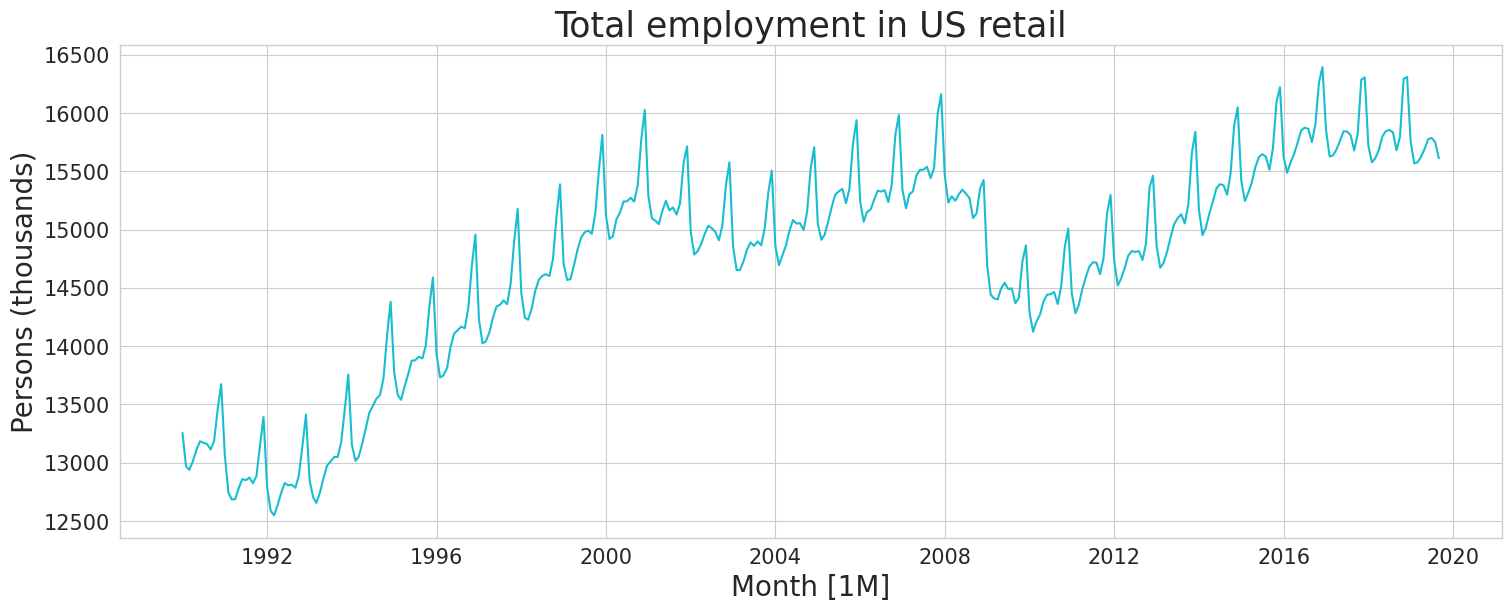

In [17]:

# US retail employment data and basic plot
us_employment = pd.read_csv("us_employment.csv", parse_dates=["ds"])
us_retail_employment = us_employment.query('(unique_id == "Retail Trade") & (ds >= "1990-01-01")')
sns.set_style("whitegrid")
plot_series(us_retail_employment, xlabel="Month [1M]", ylabel="Persons (thousands)", title="Total employment in US retail")



### Example: Seasonal and Trend decomposition using Loess (STL) decomposition method

In [18]:

# STL decomposition (default)
stl = STL(us_retail_employment["y"], period=12)
res = stl.fit()

dcmp = pd.DataFrame({
    "ds": us_retail_employment["ds"],
    "data": us_retail_employment["y"],
    "trend": res.trend,
    "seasonal": res.seasonal,
    "remainder": res.resid
}).reset_index(drop=True)

dcmp.head()


,ds,data,trend,seasonal,remainder
0,1990-01-01,13255.8,13296.249,-3.700,-36.749
1,1990-02-01,12966.3,13276.085,-288.398,-21.387
2,1990-03-01,12938.2,13255.663,-306.658,-10.805
3,1990-04-01,13012.3,13234.986,-235.775,13.089
4,1990-05-01,13108.3,13214.071,-115.399,9.628


### Example: Seasonal and Trend decomposition using Loess (STL) decomposition method

The output shows the components of an STL decomposition. The original data is shown (as data), followed by the estimated components.

The trend column (containing the trend-cycle $T_t$) follows the overall movement of the series, ignoring any seasonality and random fluctuations.

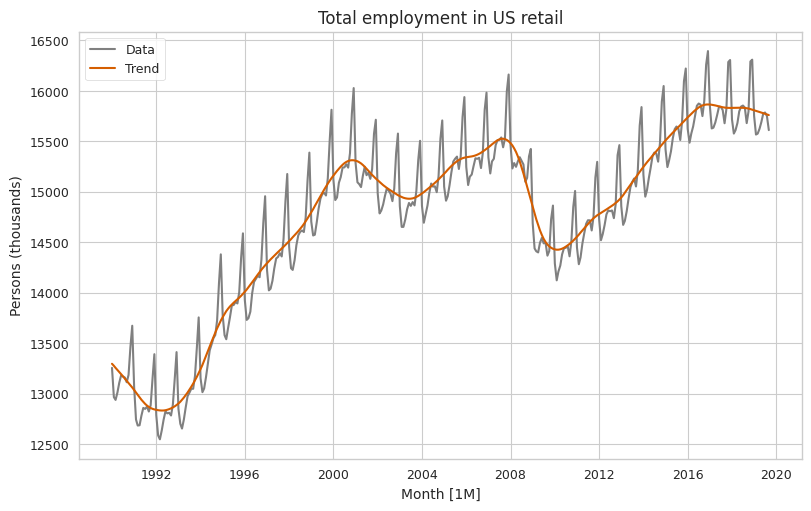

In [19]:

# Plot trend vs data
fig, ax = plt.subplots()
sns.set_style("whitegrid")
sns.lineplot(data=dcmp, x="ds", y="data", label="Data", color="gray")
sns.lineplot(data=dcmp, x="ds", y="trend", label="Trend", color="#D55E00")
ax.set_title("Total employment in US retail")
ax.set_xlabel("Month [1M]")
ax.set_ylabel("Persons (thousands)")
plt.show()


### Example: Seasonal and Trend decomposition using Loess (STL) decomposition method

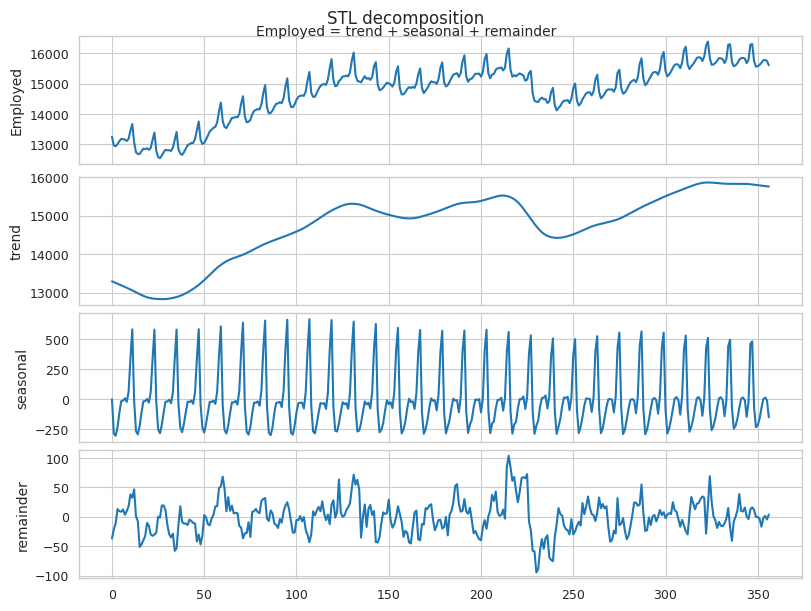

In [20]:

# Plot all components
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8, 6))
sns.set_style("whitegrid")
sns.lineplot(data=dcmp, x=dcmp.index, y="data", ax=axes[0])
sns.lineplot(data=dcmp, x=dcmp.index, y="trend", ax=axes[1])
sns.lineplot(data=dcmp, x=dcmp.index, y="seasonal", ax=axes[2])
sns.lineplot(data=dcmp, x=dcmp.index, y="remainder", ax=axes[3])
axes[0].set_ylabel("Employed")
axes[1].set_ylabel("trend")
axes[2].set_ylabel("seasonal")
axes[3].set_ylabel("remainder")
fig.suptitle("STL decomposition")
fig.subplots_adjust(top=0.90)
fig.text(0.5, 0.95, "Employed = trend + seasonal + remainder", ha='center')
plt.xlabel("")
plt.show()


### Example: Seasonal and Trend Decomposition Using Loess (STL)

The **STL decomposition method** separates a time series into three main components — **seasonal**, **trend–cycle**, and **remainder** — which together reconstruct the original data.

In the figure, the **bottom three panels** display each component individually, while the **top panel** shows the **original series**.

Key observations:

* The **seasonal component ($S_t$)** varies gradually over time — consecutive years exhibit similar patterns, but **seasonality evolves** when comparing distant years.
* The **trend–cycle component ($T_t$)** captures the **underlying direction** of the data, smoothing short-term fluctuations.
* The **remainder component ($R_t$)** represents **unexplained irregularities**, i.e., what remains after removing both the trend–cycle and seasonal effects.

These components together illustrate how **STL** provides a flexible, data-driven approach to isolating dynamic seasonal and trend structures in time series data.


## Seasonally adjusted data

If the seasonal component is removed from the original data, the resulting values are the “seasonally adjusted” data. For an additive decomposition, the seasonally adjusted data are given by $y_t - S_t$, and for multiplicative data, the seasonally adjusted values are obtained using $y_t / S_t$.


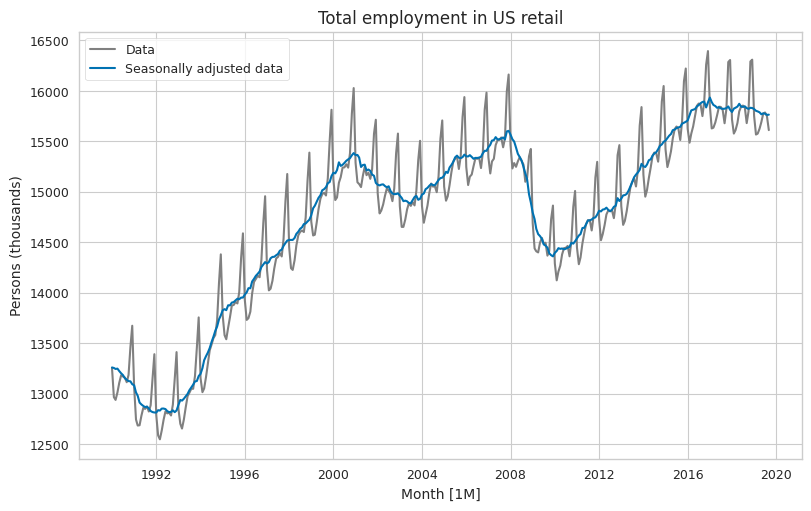

In [21]:

# Seasonally adjusted series
dcmp["season_adjust"] = dcmp["data"] - dcmp["seasonal"]

fig, ax = plt.subplots()
sns.set_style("whitegrid")
sns.lineplot(data=dcmp, x="ds", y="data", label="Data", color="gray")
sns.lineplot(data=dcmp, x="ds", y="season_adjust", label="Seasonally adjusted data", color="#0072B2")
ax.set_title("Total employment in US retail")
ax.set_xlabel("Month [1M]")
ax.set_ylabel("Persons (thousands)")
plt.show()


## Seasonally Adjusted Data

When **seasonal variation** is not the focus of analysis, it is often useful to work with a **seasonally adjusted series**, which removes predictable seasonal effects.

For example, **monthly unemployment figures** are typically **seasonally adjusted** to reveal changes in the **underlying economic conditions** rather than regular seasonal patterns.

* An increase in unemployment due to **school leavers entering the labor market** represents **seasonal variation**.
* An increase due to an **economic recession** reflects **non-seasonal variation**, which analysts seek to understand.

Because of this distinction, many **economic indicators**, including employment data, are routinely **seasonally adjusted** before analysis.

### Key Insight

A **seasonally adjusted series** combines the **trend–cycle ($T_t$)** and **remainder ($R_t$)** components:

$$
\text{Seasonally Adjusted Series} = T_t + R_t
$$

However, such data are **not perfectly smooth**, and **short-term fluctuations** may appear misleading.

* Use **seasonally adjusted data** to examine **broad economic patterns**.
* Use the **trend–cycle component** to identify **turning points** or **directional changes** with greater reliability.


## Moving Averages

The **classical method of time series decomposition**, developed in the 1920s and widely used through the 1950s, remains foundational in modern decomposition techniques.

The first step in this classical approach is to estimate the **trend–cycle component** using a **moving average** method, which smooths out short-term fluctuations to reveal long-term patterns.



### **Moving Average Smoothing**

A **moving average of order $m$** is defined as:

$$
\hat{T}*t = \frac{1}{m}\sum*{j=-k}^{k} y_{t+j},
$$

where $m = 2k + 1$.

This means that the estimated trend–cycle $\hat{T}_t$ at time $t$ is obtained by **averaging observations within $k$ periods** on either side of $t$.

### **Interpretation**

* Nearby observations are typically **similar in value**, so averaging them **reduces random noise**.

* The result is a **smoothed version of the original series**, emphasizing the **underlying trend–cycle**.

* Such a moving average is referred to as an **$m$-MA**, or a moving average of order $m$.



### Example: Australian exports of goods and services (as % of GDP) from 1960–2017


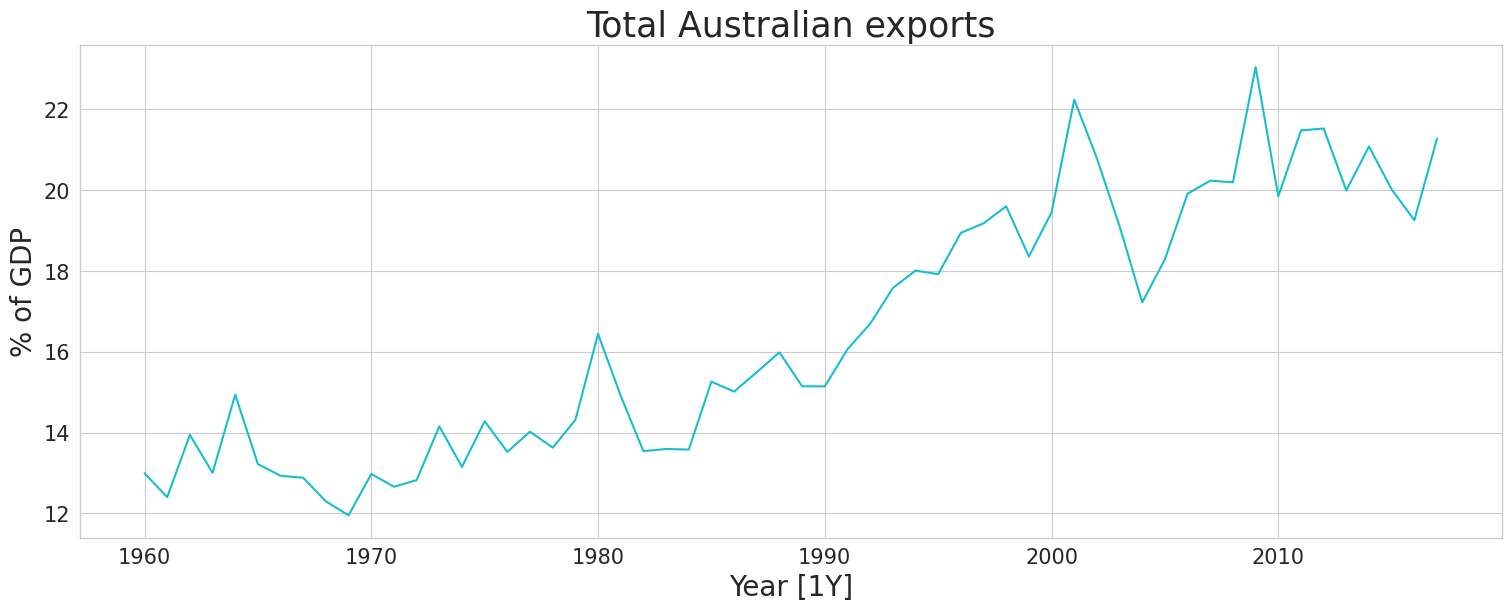

In [22]:
# Moving average smoothing example: Australian exports
global_economy = pd.read_csv("global_economy.csv")
aus_exports = global_economy.query('unique_id == "Australia"')[["unique_id", "ds", "Exports"]]

sns.set_style("whitegrid")
plot_series(aus_exports, target_col="Exports", xlabel="Year [1Y]", ylabel="% of GDP",
            title="Total Australian exports")



### Example: Australian exports of goods and services (as % of GDP) from 1960–2017

In [23]:
# --- Moving average smoothing example: Australian exports (table like the screenshot) ---

# Keep Australia, year, and exports
aus_exports = (
    global_economy
    .query('unique_id == "Australia"')[["ds", "Exports"]]
    .rename(columns={"ds": "Year"})
    .reset_index(drop=True)
)

# 5-term centered moving average
aus_exports["5-MA"] = (
    aus_exports["Exports"]
    .rolling(window=5, center=True)
    .mean()
)

# Round for display to match the printed table
tbl = aus_exports.copy()
tbl["Exports"] = tbl["Exports"].round(2)
tbl["5-MA"]    = tbl["5-MA"].round(2)

# Select the same “head … tail” view shown in the chapter:
head_part = tbl.iloc[:8]                      # 1960–1967
tail_part = tbl.iloc[-8:]                     # 2010–2017

# Insert an ellipsis row between head and tail
ellipsis = pd.DataFrame([{"Year": "…", "Exports": "…", "5-MA": "…"}])

display_tbl = pd.concat([head_part, ellipsis, tail_part], ignore_index=True)

# Rename columns to match the header in the figure
display_tbl = display_tbl.rename(columns={"5-MA": "5–MA"})  # en-dash as in book

# Show the table
display_tbl


,Year,Exports,5–MA
0,1960,12.99,NaN
1,1961,12.4,NaN
2,1962,13.94,13.46
3,1963,13.01,13.5
4,1964,14.94,13.61
5,1965,13.22,13.4
6,1966,12.93,13.25
7,1967,12.88,12.66
8,…,…,…
9,2010,19.84,21.21


### Example: Australian Exports of Goods and Services (% of GDP), 1960–2017

In this example, a **moving average of order 5** is used to estimate the **trend–cycle** component of Australia’s exports of goods and services as a percentage of GDP.

* Each entry in the **5–MA column** represents the **average of five consecutive observations**, centered on the corresponding year.
* For example:

  * The **first 5–MA value** averages data from **1960–1964**.
  * The **second 5–MA value** averages **1961–1965**, and so on.

* These values correspond to $\hat{T}_t$ with **$k = 2$** and **$m = 2k + 1 = 5$**.

Because there are no observations two years before 1960 or two years after 2017, **no moving averages can be computed at the series endpoints**.


### Example: Australian Exports of Goods and Services (% of GDP), 1960–2017

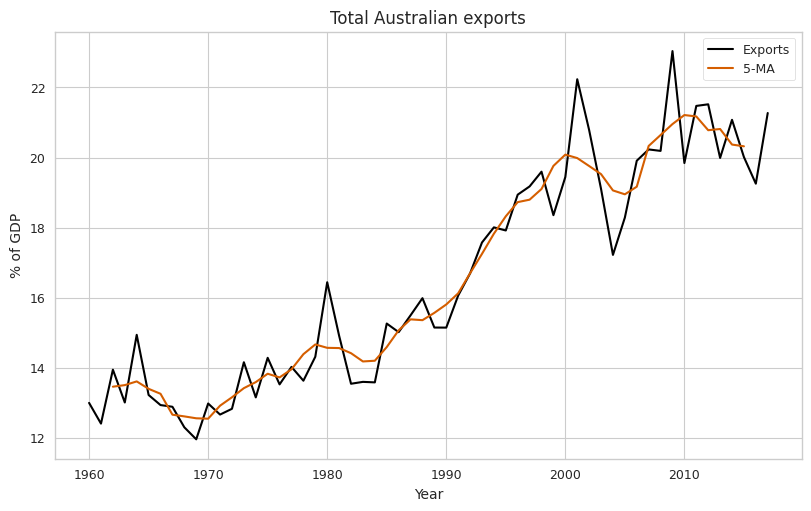

In [24]:
# Moving average smoothing example: Australian exports
global_economy = pd.read_csv("global_economy.csv")
aus_exports = global_economy.query('unique_id == "Australia"')[["unique_id", "ds", "Exports"]]

plot_series(aus_exports, target_col="Exports", xlabel="Year [1Y]", ylabel="% of GDP",
            title="Total Australian exports")
# 5-MA
aus_exports["5-MA"] = aus_exports["Exports"].rolling(window=5, center=True).mean()

fig, ax = plt.subplots()
sns.set_style("whitegrid")
sns.lineplot(data=aus_exports, x="ds", y="Exports", label="Exports", color="black")
sns.lineplot(data=aus_exports, x="ds", y="5-MA", label="5-MA", color="#D55E00")
ax.set_title("Total Australian exports")
ax.set_xlabel("Year")
ax.set_ylabel("% of GDP")
plt.show()


### Example: Australian Exports of Goods and Services (% of GDP), 1960–2017

The **trend–cycle component** (shown in orange) provides a **smoothed representation** of the original data, effectively capturing the **main long-term movements** while filtering out short-term noise.

Key insights:

* The **trend–cycle** is smoother than the raw series, emphasizing structural changes rather than random variation.

* The **order of the moving average ($m$)** determines the **degree of smoothness**:

  * A **larger $m$** produces a **smoother** and more stable curve.
  * A **smaller $m$** retains **more short-term variation**.
* The Figure demonstrates how increasing the **order of the moving average** progressively smooths the Australian export series, clarifying the underlying trend in long-term trade performance.


### Example: Australian Exports of Goods and Services (% of GDP), 1960–2017

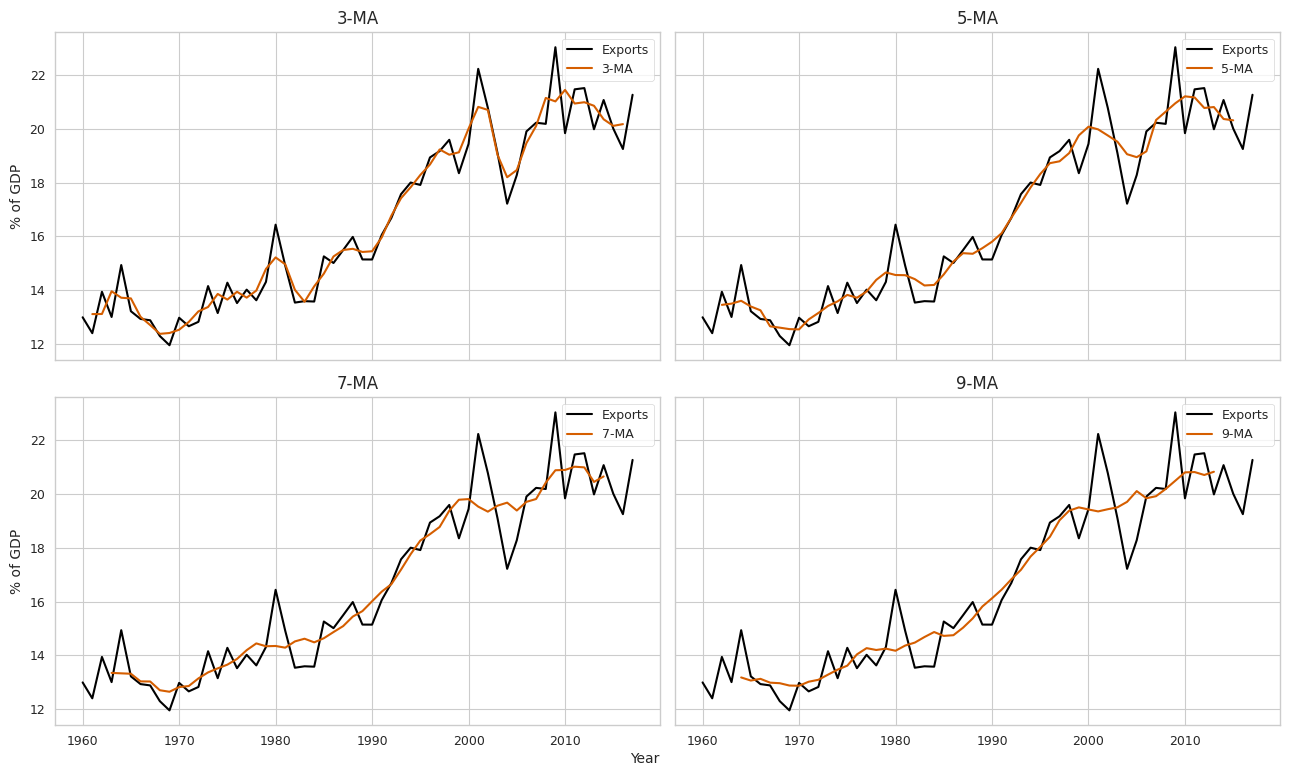

In [25]:
# --- Moving average smoothing example: Australian exports (3-, 5-, 7-, 9-MA panels) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
global_economy = pd.read_csv("global_economy.csv")
aus_exports = global_economy.query('unique_id == "Australia"')[["ds", "Exports"]].reset_index(drop=True)

# Compute centered moving averages for odd windows
for m in (3, 5, 7, 9):
    aus_exports[f"{m}-MA"] = aus_exports["Exports"].rolling(window=m, center=True).mean()

# Plot 2x2 grid
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, m in zip(axes, (3, 5, 7, 9)):
    sns.lineplot(data=aus_exports, x="ds", y="Exports", ax=ax, color="black", label="Exports")
    sns.lineplot(data=aus_exports, x="ds", y=f"{m}-MA", ax=ax, color="#D55E00", label=f"{m}-MA")
    ax.set_title(f"{m}-MA")
    ax.set_xlabel("")  # set common label later
    ax.grid(True, which="both", axis="both")

# Y labels only on left column
axes[0].set_ylabel("% of GDP")
axes[2].set_ylabel("% of GDP")
axes[1].set_ylabel("")
axes[3].set_ylabel("")

# Common X label
fig.text(0.5, 0.04, "Year", ha="center")

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()


Simple moving averages such as these are usually of an odd order (e.g., 3, 5, 7, etc.). This is so they are symmetric: in a moving average of order $m = 2k + 1$, the middle observation, and $k$ observations on either side, are averaged. But if $m$ was even, it would no longer be symmetric.


## Classical Decomposition

The **classical decomposition method**, developed in the **1920s**, serves as the **foundation for most modern time series decomposition techniques**. It provides a straightforward framework for separating a time series into its underlying components.

There are two standard forms of classical decomposition:

* **Additive decomposition**, where components are combined through addition.

* **Multiplicative decomposition**, where components interact proportionally through multiplication.

For a time series with **seasonal period $m$**, typical examples include:

* $m = 4$ for **quarterly** data,
* $m = 12$ for **monthly** data,
* $m = 7$ for **daily** data exhibiting a **weekly cycle**.

In this approach, the **seasonal component is assumed to be constant over time**, repeating identically from year to year.

For **multiplicative seasonality**, the $m$ seasonal values are known as **seasonal indices**, representing the **relative influence** of each period within the seasonal cycle.


### Additive Decomposition

The **additive classical decomposition** method separates a time series into **trend–cycle**, **seasonal**, and **remainder** components through a structured four-step process.

**Step 1 — Estimate the Trend–Cycle Component ($\hat{T}_t$)**

* If the seasonal period $m$ is **even**, use a **$2 \times m$–MA**.
* If $m$ is **odd**, use an **$m$–MA**.
  This moving average smooths short-term fluctuations to reveal the underlying trend–cycle.

**Step 2 — Detrend the Series**
Compute the **detrended values**:
$$
y_t - \hat{T}_t
$$
This removes long-term movement, isolating seasonal and irregular variations.



### Additive Decomposition

**Step 3 — Estimate the Seasonal Component ($\hat{S}_t$)**
For each season (e.g., month or quarter), **average the detrended values** across years.

* Example: For monthly data, the March seasonal component equals the **average of all detrended March values**.
* Adjust these averages to ensure they **sum to zero**.
* Replicate the seasonal pattern across all years to obtain $\hat{S}_t$.

**Step 4 — Compute the Remainder Component ($\hat{R}_t$)**
Subtract both estimated components from the original data:
$$
\hat{R}_t = y_t - \hat{T}_t - \hat{S}_t
$$


#### Example: A classical additive decomposition of US retail employment

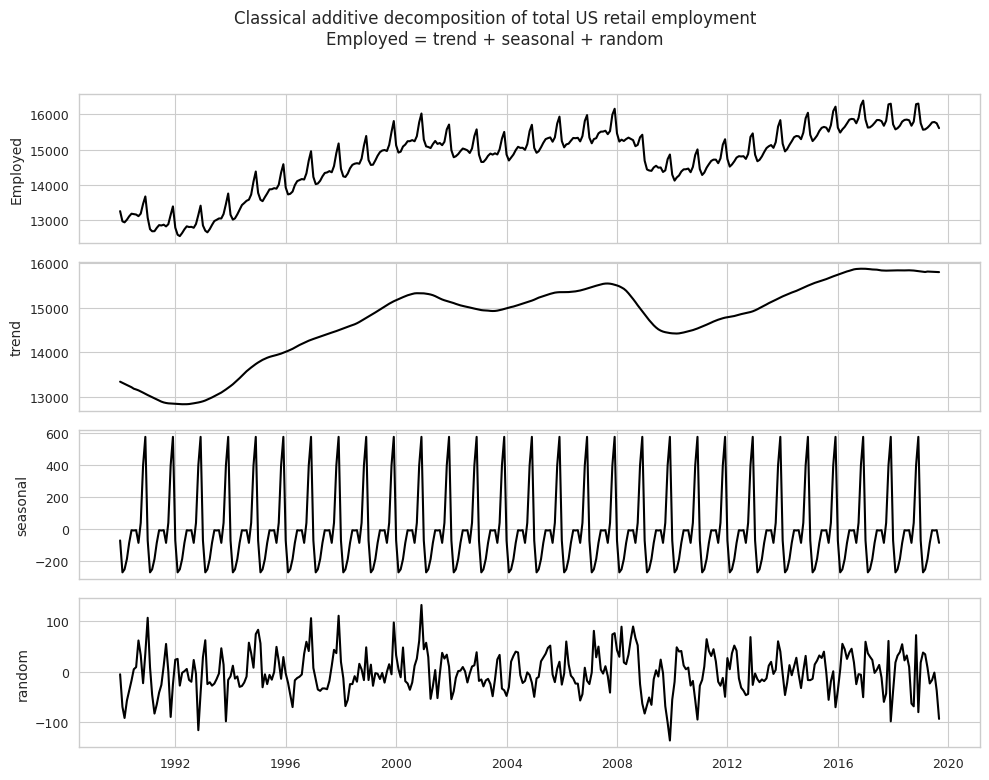

In [26]:
# --- Classical additive decomposition of US retail employment (monthly, period=12) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# 1) Load & filter series
us_employment = pd.read_csv("us_employment.csv", parse_dates=["ds"])
us_retail = (
    us_employment
    .query('(unique_id == "Retail Trade") & (ds >= "1990-01-01")')
    .loc[:, ["ds", "y"]]
    .set_index("ds")
    .asfreq("MS")              # ensure regular monthly frequency
)

# 2) Classical decomposition (additive) using 2×m MA for trend internally
#    period = 12 for monthly seasonality
decomp = seasonal_decompose(
    us_retail["y"],
    model="additive",
    period=12,
    two_sided=True,            # centered moving average
    extrapolate_trend="freq"   # extends ends to plot the trend line
)

# 3) Collect components
dcmp = pd.DataFrame({
    "data":     decomp.observed,
    "trend":    decomp.trend,
    "seasonal": decomp.seasonal,
    "random":   decomp.resid
}, index=us_retail.index)

# 4) Plot four panels to match the figure
sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axes[0].plot(dcmp.index, dcmp["data"], color="black")
axes[0].set_ylabel("Employed")

axes[1].plot(dcmp.index, dcmp["trend"], color="black")
axes[1].set_ylabel("trend")

axes[2].plot(dcmp.index, dcmp["seasonal"], color="black")
axes[2].set_ylabel("seasonal")

axes[3].plot(dcmp.index, dcmp["random"], color="black")
axes[3].set_ylabel("random")

fig.suptitle("Classical additive decomposition of total US retail employment\n"
             "Employed = trend + seasonal + random", y=0.97)
axes[-1].set_xlabel("")  # figure has no explicit x-label in the book figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Multiplicative Decomposition

The **classical multiplicative decomposition** follows the same logical structure as the additive version, except that **additions and subtractions are replaced by multiplications and divisions**.

**Step 1 — Estimate the Trend–Cycle Component ($\hat{T}_t$)**

* If the seasonal period $m$ is **even**, use a **$2 \times m$–MA**.
* If $m$ is **odd**, use an **$m$–MA**.
  This smooths the data to estimate the underlying trend–cycle.

**Step 2 — Detrend the Series**
Remove the estimated trend–cycle by **division**:
$$
\frac{y_t}{\hat{T}_t}
$$



### Multiplicative Decomposition

**Step 3 — Estimate the Seasonal Component ($\hat{S}_t$)**

* For each season (e.g., each month), compute the **average of the detrended values**.
* Example: For monthly data, the **seasonal index for March** equals the **average of all detrended March values**.
* Adjust the seasonal indexes so that their **sum equals $m$**.
* Replicate the sequence across all years to form $\hat{S}_t$.

**Step 4 — Compute the Remainder Component ($\hat{R}_t$)**
Remove both the trend–cycle and seasonal effects:
$$
\hat{R}_t = \frac{y_t}{\hat{T}_t \hat{S}_t}
$$



## Comments on Classical Decomposition

While **classical decomposition** remains conceptually important and historically influential, it is **not recommended for practical forecasting** today.
Modern techniques—such as **STL decomposition** and **model-based approaches**—offer **greater flexibility, robustness, and accuracy**.

For a deeper discussion, refer to [Chapter 3 of *Forecasting: Principles and Practice, the Pythonic Way*](https://otexts.com/fpppy/nbs/03-decomposition.html).


## STL Decomposition

**STL (Seasonal and Trend decomposition using Loess)** is a **flexible and robust method** for decomposing time series into trend, seasonal, and remainder components.

Developed by **Cleveland et al. (1990)** and later extended by **Bandara, Hyndman, and Bergmeir (2022)**, it uses **Loess smoothing** to estimate nonlinear trends.



### **Key Advantages of STL**

* Handles **any type of seasonality**, not limited to monthly or quarterly data (unlike SEATS and X–11).
* Allows the **seasonal component to evolve over time**, with user control over the rate of change.
* Provides **adjustable smoothness** for the trend–cycle component.
* Offers a **robust decomposition option**, making it resistant to outliers — unusual observations affect only the remainder component, not the trend or seasonality.



### **Limitations of STL**

* Does **not automatically adjust** for **trading-day or calendar effects**.

* Supports **only additive decompositions** directly.



### **Transformations for Alternative Forms**

* A **multiplicative decomposition** can be obtained by applying a **log transformation** before STL and then **back-transforming** the components.
* Intermediate decompositions can be created using a **Box–Cox transformation** with parameter $0 < \lambda < 1$:

  * $\lambda = 0$ → multiplicative decomposition
  * $\lambda = 1$ → additive decomposition



### **Practical Use**

The most effective way to master STL is through **experimentation and visualization**.

We will se it applied to **US retail employment data** and check an alternative decomposition where the **trend–cycle is more flexible**, the **seasonal pattern is fixed**, and the **robust option** is enabled to handle outliers.

### Example: Total US retail employment (top) and its three additive components obtained from a robust STL decomposition with flexible trend-cycle and fixed seasonality.

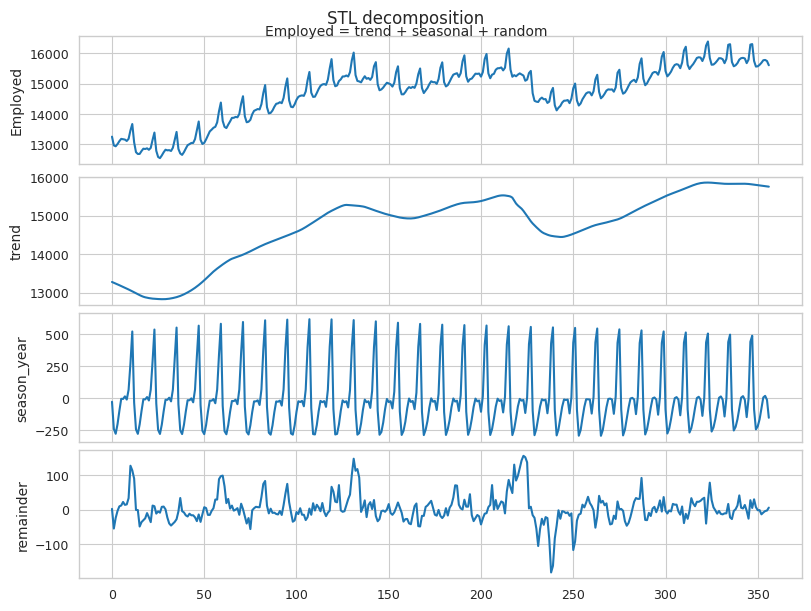

In [27]:

# Robust STL with flexible trend / fixed season
stl = STL(us_retail_employment["y"], period=12, seasonal=13, trend=21, robust=True)
res_stl = stl.fit()

dcmp = pd.DataFrame({
    "ds": us_retail_employment["ds"],
    "data": us_retail_employment["y"],
    "trend": res_stl.trend,
    "seasonal": res_stl.seasonal,
    "remainder": res_stl.resid
}).reset_index(drop=True)

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8, 6))
sns.lineplot(data=dcmp, x=dcmp.index, y="data", ax=axes[0])
sns.lineplot(data=dcmp, x=dcmp.index, y="trend", ax=axes[1])
sns.lineplot(data=dcmp, x=dcmp.index, y="seasonal", ax=axes[2])
sns.lineplot(data=dcmp, x=dcmp.index, y="remainder", ax=axes[3])
axes[0].set_ylabel("Employed")
axes[1].set_ylabel("trend")
axes[2].set_ylabel("season_year")
axes[3].set_ylabel("remainder")
fig.suptitle("STL decomposition")
fig.subplots_adjust(top=0.90)
fig.text(0.5, 0.95, "Employed = trend + seasonal + random", ha="center")
plt.xlabel("")
plt.show()


### Example: Total US Retail Employment and Its STL Components

The figure shows the **total US retail employment** series (top) along with its **three additive components** — trend–cycle, seasonality, and remainder — obtained from a **robust STL decomposition** with a **flexible trend–cycle** and **fixed seasonality**.

#### **Key STL Parameters**

When applying STL, two parameters must be defined:

* **Season:** the length of the **seasonal smoother**, controlling how quickly the seasonal pattern can evolve.
* **Trend:** the length of the **trend smoother**, determining how flexibly the trend–cycle can adjust to structural changes.

Both parameters must be **odd numbers**.
Smaller values make the corresponding component **more responsive** to rapid fluctuations.




#### **Interpretation of the Example**

In the default STL output, the **trend window** was too long, making the **trend–cycle too rigid**.
This caused **signal leakage** — notably, the 2008 **global financial crisis impact** appeared in the **remainder component** instead of the trend.
Adjusting to a **shorter trend window** (as in Figure 3.12) yields a more **accurate and responsive trend–cycle estimate**.


# 5 - Some simple forecasting methods

> Source: Chapter 5 “The forecaster’s toolbox” (FPP, Pythonic Way).  
> URL: https://otexts.com/fpppy/nbs/05-toolbox.html

Some forecasting methods are extremely simple and surprisingly effective. We will use four simple forecasting methods as benchmarks throughout this book. To illustrate them, we will use quarterly Australian clay brick production between 1970 and 2004.

## Setup


In [28]:
!pip -q install utilsforecast statsmodels seaborn matplotlib cycler
!pip install fpppy
# Ensure these are available:
# - boxcox() function — For applying Box–Cox transformations
# - boxcox_lambda() function — For finding optimal Box–Cox transformation parameters
# - plot_series() utility — For creating time series visualizations

import sys, importlib, subprocess

def _pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-qU", pkg], check=True)

# 1) coreforecast: boxcox, boxcox_lambda
try:
    from coreforecast.scalers import boxcox, boxcox_lambda
except Exception:
    _pip_install("coreforecast")
    from coreforecast.scalers import boxcox, boxcox_lambda

# 2) plot_series utility: prefer fpppy.utils, fallback to utilsforecast.plotting
try:
    from fpppy.utils import plot_series  # if you have the FPP(Pythonic) helpers
except Exception:
    try:
        from utilsforecast.plotting import plot_series  # fallback
    except Exception:
        _pip_install("utilsforecast matplotlib pandas numpy")
        from utilsforecast.plotting import plot_series

# --- quick smoke test / confirmation ---
def _has_callable(obj):
    try:
        return callable(obj)
    except Exception:
        return False

print("• boxcox() function —", "OK" if _has_callable(boxcox) else "MISSING")
print("• boxcox_lambda() function —", "OK" if _has_callable(boxcox_lambda) else "MISSING")
print("• plot_series() utility —", "OK" if _has_callable(plot_series) else "MISSING")

# Optional: tiny demo to verify they actually run (safe no-op)
import numpy as np
y = np.array([1.0, 2.0, 4.0, 8.0])
lam = boxcox_lambda(y, method="guerrero", season_length=2)
_ = boxcox(y, lam)  # should not error


• boxcox() function — OK
• boxcox_lambda() function — OK
• plot_series() utility — OK


In [29]:
import sys, subprocess
def pip_install(*pkgs):
    subprocess.run([sys.executable, "-m", "pip", "install", "-qU", *pkgs], check=True)

# tsfeatures is published by Nixtla. These are commonly used together:
pip_install("tsfeatures", "statsforecast", "coreforecast")


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage
from utilsforecast.plotting import plot_series


production_df = pd.read_csv("aus_production_formatted.csv", parse_dates=["ds"])
production_df.head()

,unique_id,ds,y
0,Beer,1956-03-01,284.0
1,Beer,1956-06-01,213.0
2,Beer,1956-09-01,227.0
3,Beer,1956-12-01,308.0
4,Beer,1957-03-01,262.0


## Mean method

Here, the forecasts of all future values are equal to the average (or “mean”) of the historical data. If we let the historical data be denoted by $y_1, \ldots, y_T$, then we can write the forecasts as

$$\hat{y}_{T+h\mid T} = \bar{y} = \frac{y_1 + \cdots + y_T}{T}.$$

The notation $\hat{y}_{T+h\mid T}$ is a short-hand for the estimate of $y_{T+h}$ based on the data $y_1, \ldots, y_T$.

```python
avg_method = HistoricAverage()
sf = StatsForecast(models=[avg_method], freq='QE')
```

### Example: Mean (or average) forecasts applied to clay brick production in Australia.

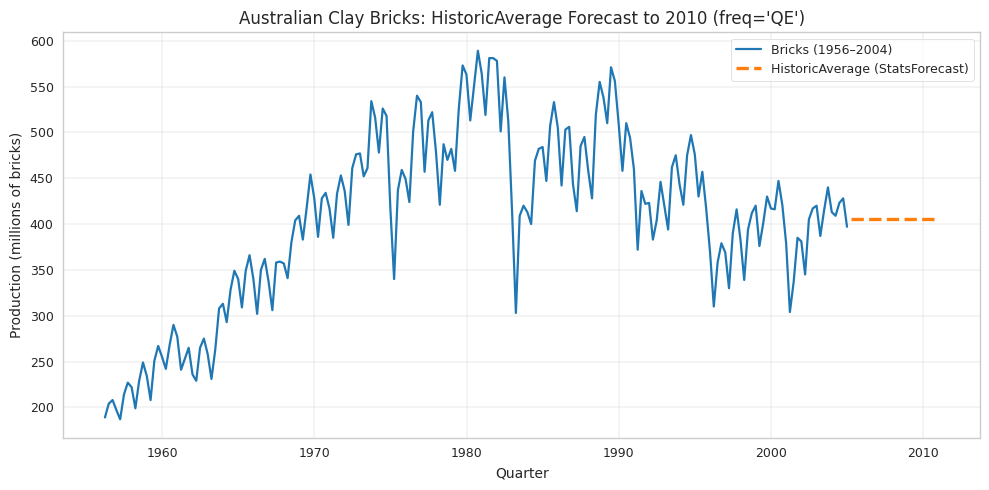

{'train_window': ['1956-03-31', '2004-12-31'], 'n_obs': 196, 'h_quarters': 24, 'last_training_quarter': '2004Q4', 'forecast_end_quarter': '2010Q4', 'forecast_value_column': 'HistoricAverage'}


In [31]:
# Forecast Australian clay brick production (1956–2004) out to 2010
# Approach: StatsForecast with HistoricAverage(), quarterly frequency
# Robust to StatsForecast's column naming (uses model-name column)
# Plot without confidence intervals; y-axis optional

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage
from pandas.tseries.offsets import MonthEnd

# ----------------------------
# Load and prepare quarterly data (quarter-end timestamps)
# ----------------------------
path = "aus_production_formatted.csv"
df = pd.read_csv(path, parse_dates=["ds"])

bricks = (
    df.query('unique_id == "Bricks"')
      .loc[:, ["unique_id", "ds", "y"]]
      .sort_values("ds")
      .assign(ds=lambda d: d["ds"] + MonthEnd(0))  # align to quarter-end so freq='QE' is consistent
)

# Training window (through 2004 inclusive, as in your code)
train = bricks.query('ds <= "2004-12-31"').reset_index(drop=True)
if train.empty:
    raise ValueError("No Bricks observations found through 2004. Check the file and date ranges.")

last_ds = train["ds"].max()                 # last observed quarter-end in training
end_ds  = pd.Timestamp("2010-12-31")        # forecast end (quarter-end)

# ----------------------------
# Horizon (number of quarters to 2010Q4)
# ----------------------------
last_q = last_ds.to_period("Q")
end_q  = end_ds.to_period("Q")
h = (end_q.year - last_q.year) * 4 + (end_q.quarter - last_q.quarter)
if h <= 0:
    raise ValueError("Computed horizon h <= 0; verify last_ds and end_ds.")

# ----------------------------
# StatsForecast: HistoricAverage
# ----------------------------
avg_method = HistoricAverage()
sf = StatsForecast(models=[avg_method], freq="QE")  # quarter-end
fcasts = sf.forecast(df=train, h=h)

# Determine the forecast value column. Newer versions name it after the model.
value_cols = [c for c in fcasts.columns if c not in ("unique_id", "ds")]
if not value_cols:
    raise ValueError(
        f"Forecast dataframe has columns {list(fcasts.columns)} but no value column. "
        "Expected a model-named column like 'HistoricAverage'."
    )
yhat_col = value_cols[0]   # e.g., 'HistoricAverage'

# ----------------------------
# Plot history + historic-average forecast (ensure non-black colors)
# ----------------------------
# Reset any global monochrome override some earlier cell may have set
mpl.rcParams['axes.prop_cycle'] = mpl.rcParamsDefault['axes.prop_cycle']

fig, ax = plt.subplots(figsize=(10, 5))

# Use explicit non-cycle colors to be robust in Colab
train_label = f'Bricks ({train["ds"].min().year}–{train["ds"].max().year})'
ax.plot(train["ds"], train["y"], label=train_label, linewidth=1.6, color="tab:blue")
ax.plot(fcasts["ds"], fcasts[yhat_col], "--", linewidth=2.4,
        label="HistoricAverage (StatsForecast)", color="tab:orange")

ax.set_title("Australian Clay Bricks: HistoricAverage Forecast to 2010 (freq='QE')")
ax.set_xlabel("Quarter")
ax.set_ylabel("Production (millions of bricks)")
# ax.set_ylim(300, 600)  # optional bound if desired
ax.legend(loc="best")
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

print({
    "train_window": [train["ds"].min().date().isoformat(), train["ds"].max().date().isoformat()],
    "n_obs": int(len(train)),
    "h_quarters": int(h),
    "last_training_quarter": str(last_q),
    "forecast_end_quarter": str(end_q),
    "forecast_value_column": yhat_col
})


## Naïve method

For naïve forecasts, we simply set all forecasts to be the value of the last observation. That is,

$$\hat{y}_{T+h\mid T}=y_T.$$

This method works remarkably well for many economic and financial time series.

```python
naive_method = Naive()
sf = StatsForecast(models=[naive_method], freq='QE')
```

### Example: Naïve forecasts applied to clay brick production in Australia.

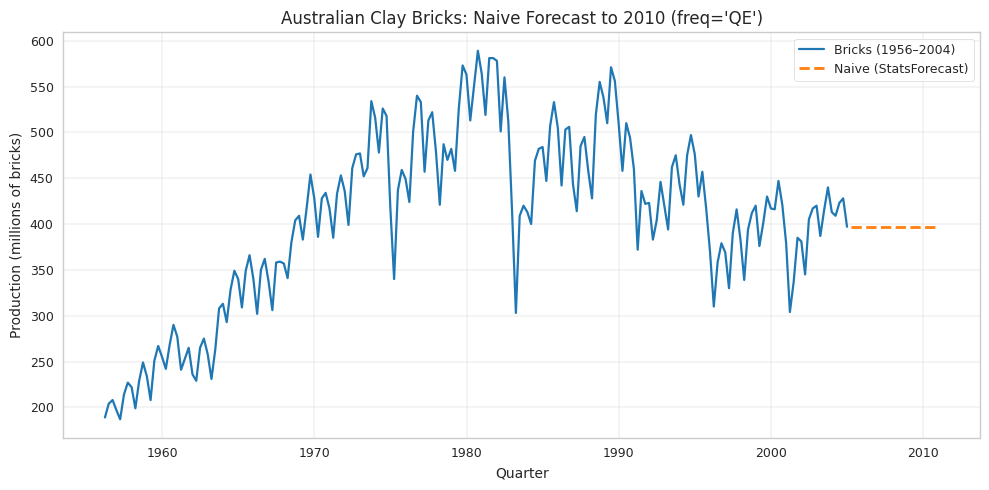

{'train_window': ['1956-03-31', '2004-12-31'], 'n_obs': 196, 'h_quarters': 24, 'last_training_quarter': '2004Q4', 'forecast_end_quarter': '2010Q4', 'forecast_value_column': 'Naive'}


In [32]:
# Forecast Australian clay brick production (1956–2004) out to 2010
# Approach: StatsForecast with Naive() at quarterly frequency
# Plot without confidence intervals; y-axis fixed to [300, 600]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import Naive
from pandas.tseries.offsets import MonthEnd

# ----------------------------
# Load and prepare quarterly data (quarter-end timestamps)
# ----------------------------
path = "aus_production_formatted.csv"
df = pd.read_csv(path, parse_dates=["ds"])

bricks = (
    df.query('unique_id == "Bricks"')
      .loc[:, ["unique_id", "ds", "y"]]
      .sort_values("ds")
      .assign(ds=lambda d: d["ds"] + MonthEnd(0))   # align to quarter-end
)

# Training window 1970–2004 inclusive

# train = bricks.query('ds >= "1970-01-01" and ds <= "2004-12-31"').reset_index(drop=True)
train = bricks.query('ds <= "2004-12-31"').reset_index(drop=True)

if train.empty:
    raise ValueError("No Bricks observations found in 1970–2004. Check the file and date ranges.")

last_ds = train["ds"].max()
end_ds  = pd.Timestamp("2010-12-31")

# ----------------------------
# Horizon (quarters from last_ds to 2010Q4)
# ----------------------------
last_q = last_ds.to_period("Q")
end_q  = end_ds.to_period("Q")
h = (end_q.year - last_q.year) * 4 + (end_q.quarter - last_q.quarter)
if h <= 0:
    raise ValueError("Computed horizon h <= 0; verify last_ds and end_ds.")

# ----------------------------
# StatsForecast: Naive
# ----------------------------
nav_method = Naive()
sf = StatsForecast(models=[nav_method], freq="QE")   # quarter-end frequency
fcasts = sf.forecast(df=train, h=h)

# Model output column (StatsForecast names it after the model)
value_cols = [c for c in fcasts.columns if c not in ("unique_id", "ds")]
if not value_cols:
    raise ValueError(
        f"Forecast dataframe has columns {list(fcasts.columns)} but no value column. "
        "Expected a model-named column like 'Naive'."
    )
yhat_col = value_cols[0]   # typically 'Naive'

# ----------------------------
# Plot history + naive forecast (no intervals)
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train["ds"], train["y"], label="Bricks (1956–2004)", linewidth=1.6)
ax.plot(fcasts["ds"], fcasts[yhat_col], "--", linewidth=2, label="Naive (StatsForecast)")

ax.set_title("Australian Clay Bricks: Naive Forecast to 2010 (freq='QE')")
ax.set_xlabel("Quarter")
ax.set_ylabel("Production (millions of bricks)")
# ax.set_ylim(300, 600)
ax.legend(loc="best")
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

print({
    "train_window": [train["ds"].min().date().isoformat(), train["ds"].max().date().isoformat()],
    "n_obs": int(len(train)),
    "h_quarters": int(h),
    "last_training_quarter": str(last_q),
    "forecast_end_quarter": str(end_q),
    "forecast_value_column": yhat_col
})


Because a naïve forecast is optimal when data follow a random walk (see Section 9.1), these are also called random walk forecasts.

## Seasonal Naïve Method with Period $m$

The **seasonal naïve method** is particularly effective for **highly seasonal time series**.
It assumes that each observation repeats the value from the **same season in the previous cycle**.

Formally, the forecast for time $T + h$ is defined as:

$$
\hat{y}*{T+h \mid T} = y*{T + h - m(k+1)},
$$

where:

* $m$ = seasonal period (e.g., 12 for monthly data, 4 for quarterly data),
* $k$ = integer part of $(h - 1)/m$, representing the **number of complete seasons** in the forecast horizon prior to $T + h$.

### **Interpretation**

* For **monthly data**, all future **February** forecasts equal the **last observed February** value.
* For **quarterly data**, all future **Q2** forecasts equal the **last observed Q2** value.
* The same logic extends to other seasonal periods.

### Example: Seasonal naïve forecasts applied to clay brick production in Australia.

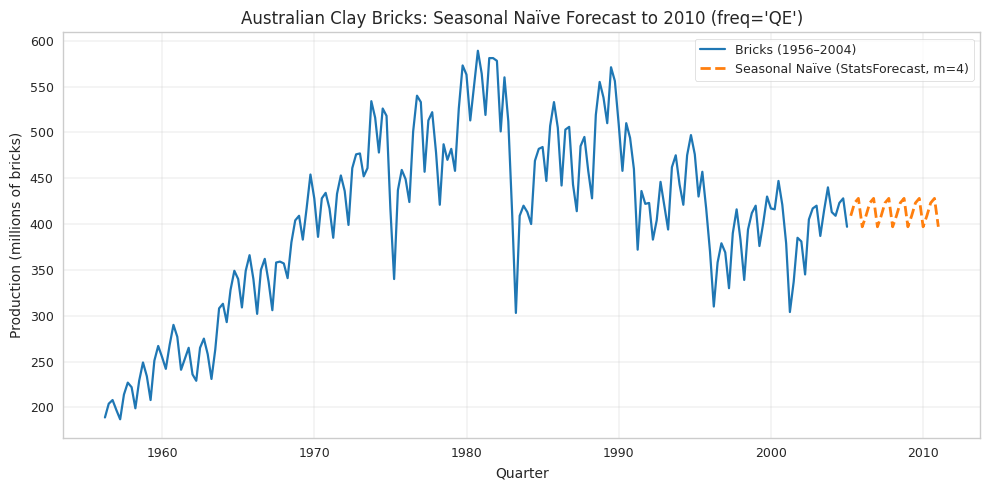

{'train_window': ['1956-03-31', '2004-12-31'], 'n_obs': 196, 'h_quarters': 24, 'last_training_quarter': '2004Q4', 'forecast_end_quarter': '2010Q4', 'forecast_value_column': 'SeasonalNaive'}


In [33]:
# Forecast Australian clay brick production (1970–2004) out to 2010
# Approach: StatsForecast SeasonalNaive (m=4, quarterly)
# Plot without confidence intervals; y-axis fixed to [300, 600]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from pandas.tseries.offsets import MonthEnd

# ----------------------------
# Load and prepare quarterly data (quarter-end timestamps)
# ----------------------------
path = "aus_production_formatted.csv"
df = pd.read_csv(path, parse_dates=["ds"])

bricks = (
    df.query('unique_id == "Bricks"')
      .loc[:, ["unique_id", "ds", "y"]]
      .sort_values("ds")
      .assign(ds=lambda d: d["ds"] + MonthEnd(0))   # align to quarter-end
)

# Training window 1970–2004 inclusive
# train = bricks.query('ds >= "1970-01-01" and ds <= "2004-12-31"').reset_index(drop=True)
train = bricks.query('ds <= "2004-12-31"').reset_index(drop=True)
if train.empty:
    raise ValueError("No Bricks observations found in 1970–2004. Check the file and date ranges.")

last_ds = train["ds"].max()
end_ds  = pd.Timestamp("2010-12-31")

# ----------------------------
# Horizon (quarters from last_ds to 2010Q4)
# ----------------------------
last_q = last_ds.to_period("Q")
end_q  = end_ds.to_period("Q")
h = (end_q.year - last_q.year) * 4 + (end_q.quarter - last_q.quarter)
if h <= 0:
    raise ValueError("Computed horizon h <= 0; verify last_ds and end_ds.")

# ----------------------------
# StatsForecast: Seasonal Naive (m = 4 for quarterly)
# ----------------------------
snaive = SeasonalNaive(season_length=4)
sf = StatsForecast(models=[snaive], freq="QE")   # quarter-end frequency
fcasts = sf.forecast(df=train, h=h)

# Model output column (StatsForecast names it after the model)
value_cols = [c for c in fcasts.columns if c not in ("unique_id", "ds")]
if not value_cols:
    raise ValueError(
        f"Forecast dataframe has columns {list(fcasts.columns)} but no value column. "
        "Expected a model-named column like 'SeasonalNaive'."
    )
yhat_col = value_cols[0]   # typically 'SeasonalNaive'

# ----------------------------
# Plot history + seasonal naive forecast (no intervals)
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train["ds"], train["y"], label="Bricks (1956–2004)", linewidth=1.6)
ax.plot(fcasts["ds"], fcasts[yhat_col], "--", linewidth=2, label="Seasonal Naïve (StatsForecast, m=4)")

ax.set_title("Australian Clay Bricks: Seasonal Naïve Forecast to 2010 (freq='QE')")
ax.set_xlabel("Quarter")
ax.set_ylabel("Production (millions of bricks)")
# ax.set_ylim(300, 600)
ax.legend(loc="best")
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

print({
    "train_window": [train["ds"].min().date().isoformat(), train["ds"].max().date().isoformat()],
    "n_obs": int(len(train)),
    "h_quarters": int(h),
    "last_training_quarter": str(last_q),
    "forecast_end_quarter": str(end_q),
    "forecast_value_column": yhat_col
})


## Drift Method

The **drift method** is a variation of the **naïve forecasting approach**, where forecasts are allowed to **increase or decrease linearly over time**.
The rate of change, known as the **drift**, equals the **average historical change** between consecutive observations.

The forecast for time $T + h$ is given by:

$$
\hat{y}*{T+h \mid T} = y_T + \frac{h}{T - 1} \sum*{t=2}^{T}(y_t - y_{t-1}) = y_T + h \left( \frac{y_T - y_1}{T - 1} \right).
$$

### **Interpretation**

* The method effectively **draws a straight line** between the **first and last observations** of the series.
* Future values are **extrapolated linearly**, assuming that the historical rate of change continues.
* It captures simple **trend behavior** while maintaining the **structure of a random walk**.

This approach is particularly useful for **series with a steady trend**, as it extends the historical direction of movement into the forecast horizon.


### Example: Drift forecasts applied to clay brick production in Australia

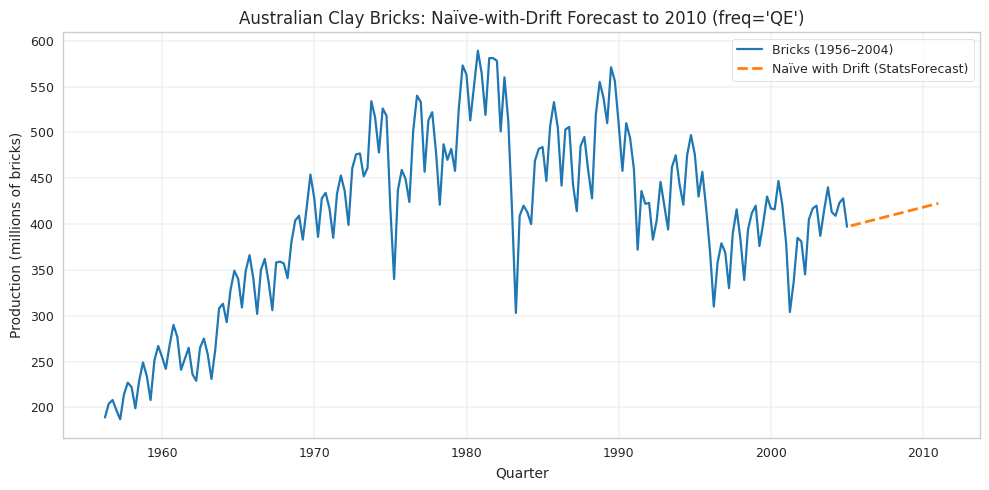

{'train_window': ['1956-03-31', '2004-12-31'], 'n_obs': 196, 'h_quarters': 24, 'last_training_quarter': '2004Q4', 'forecast_end_quarter': '2010Q4', 'forecast_value_column': 'RWD'}


In [34]:
# Forecast Australian clay brick production (1970–2004) out to 2010
# Approach: StatsForecast RandomWalkWithDrift() (a.k.a. naïve with drift)
# Plot without confidence intervals; y-axis fixed to [300, 600]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import RandomWalkWithDrift
from pandas.tseries.offsets import MonthEnd

# ----------------------------
# Load and prepare quarterly data (quarter-end timestamps)
# ----------------------------
path = "aus_production_formatted.csv"
df = pd.read_csv(path, parse_dates=["ds"])

bricks = (
    df.query('unique_id == "Bricks"')
      .loc[:, ["unique_id", "ds", "y"]]
      .sort_values("ds")
      .assign(ds=lambda d: d["ds"] + MonthEnd(0))   # align to quarter-end for 'QE'
)

# Training window 1970–2004 inclusive
# train = bricks.query('ds >= "1970-01-01" and ds <= "2004-12-31"').reset_index(drop=True)
train = bricks.query('ds <= "2004-12-31"').reset_index(drop=True)
if train.empty:
    raise ValueError("No Bricks observations found in 1970–2004. Check the file and date ranges.")

last_ds = train["ds"].max()
end_ds  = pd.Timestamp("2010-12-31")

# ----------------------------
# Horizon (quarters from last_ds to 2010Q4)
# ----------------------------
last_q = last_ds.to_period("Q")
end_q  = end_ds.to_period("Q")
h = (end_q.year - last_q.year) * 4 + (end_q.quarter - last_q.quarter)
if h <= 0:
    raise ValueError("Computed horizon h <= 0; verify last_ds and end_ds.")

# ----------------------------
# StatsForecast: Random Walk with Drift
# ----------------------------
drift_method = RandomWalkWithDrift()
sf = StatsForecast(models=[drift_method], freq="QE")   # quarter-end frequency
fcasts = sf.forecast(df=train, h=h)                    # columns: unique_id, ds, RandomWalkWithDrift

# Get the forecast value column (named after the model)
value_cols = [c for c in fcasts.columns if c not in ("unique_id", "ds")]
if not value_cols:
    raise ValueError(f"Unexpected forecast columns: {list(fcasts.columns)}")
yhat_col = value_cols[0]  # typically 'RandomWalkWithDrift'

# ----------------------------
# Plot history + drift forecast
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train["ds"], train["y"], label="Bricks (1956–2004)", linewidth=1.6)
ax.plot(fcasts["ds"], fcasts[yhat_col], "--", linewidth=2, label="Naïve with Drift (StatsForecast)")

ax.set_title("Australian Clay Bricks: Naïve-with-Drift Forecast to 2010 (freq='QE')")
ax.set_xlabel("Quarter")
ax.set_ylabel("Production (millions of bricks)")
# ax.set_ylim(300, 600)
ax.legend(loc="best")
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

print({
    "train_window": [train["ds"].min().date().isoformat(), train["ds"].max().date().isoformat()],
    "n_obs": int(len(train)),
    "h_quarters": int(h),
    "last_training_quarter": str(last_q),
    "forecast_end_quarter": str(end_q),
    "forecast_value_column": yhat_col
})


## Example: Australian Quarterly Beer Production

The figure illustrates the application of the **first three forecasting methods** —
**naïve**, **seasonal naïve**, and **drift** — to **Australian quarterly beer production** data covering the period **1992–2006**.

The **forecasts** generated by each method are compared with the **actual observations** over the **subsequent 3.5 years**, providing a clear visualization of how each approach captures trend and seasonality in the data.

This example highlights the differences in performance between the methods when dealing with **seasonal patterns** and **gradual trends** in quarterly production data.

In this case, only the seasonal naïve forecasts are close to the observed values from 2007 onwards.



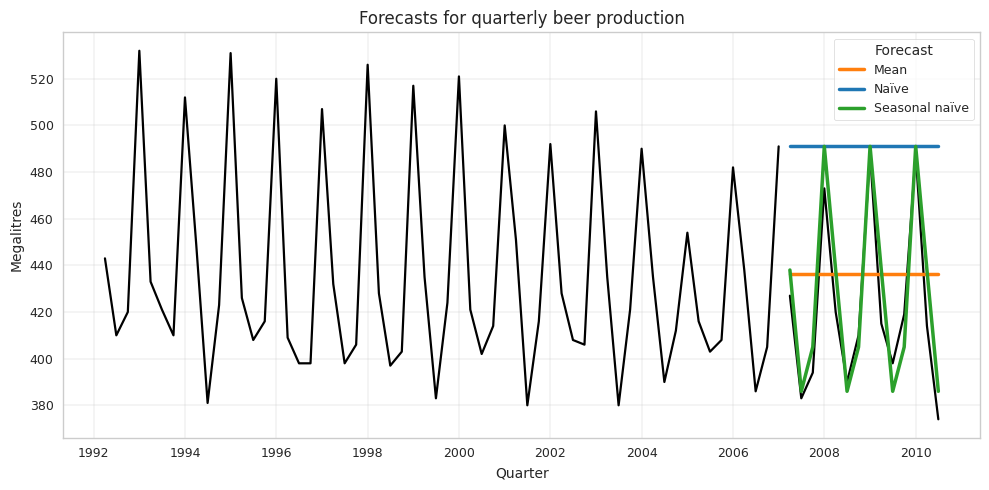

In [35]:
# Forecasts for quarterly beer production (1992–2006) with 3.5-year holdout
# Models: Naïve, Mean (HistoricAverage), Seasonal Naïve
# Plot forecasts against actuals for the next 14 quarters with distinct colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd, QuarterEnd
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, SeasonalNaive

# ----------------------------
# Load data and prepare quarterly timestamps
# ----------------------------
path = "aus_production_formatted.csv"
df = pd.read_csv(path, parse_dates=["ds"])

beer = (
    df.query('unique_id == "Beer"')
      .loc[:, ["unique_id", "ds", "y"]]
      .sort_values("ds")
      .assign(ds=lambda d: d["ds"] + MonthEnd(0))  # align to quarter-end for freq='QE'
)

# ----------------------------
# Train window and horizon
# ----------------------------
train = beer.query('ds >= "1992-01-01" and ds <= "2006-12-31"').reset_index(drop=True)
if train.empty:
    raise ValueError("No Beer observations found in 1992–2006.")

last_train_ds = train["ds"].max()   # 2006Q4 quarter-end
h = 14                              # 3.5 years = 14 quarters
end_ds = last_train_ds + QuarterEnd(h)

# ----------------------------
# StatsForecast models
# ----------------------------
sf = StatsForecast(
    models=[Naive(), HistoricAverage(), SeasonalNaive(season_length=4)],
    freq="QE"
)
fcasts = sf.forecast(df=train, h=h)

# Normalize model column names
rename_map = {}
for c in fcasts.columns:
    if c in ("unique_id", "ds"):
        continue
    cl = c.lower()
    if "historicaverage" in cl or cl == "mean":
        rename_map[c] = "Mean"
    elif cl == "naive":
        rename_map[c] = "Naïve"
    elif "seasonalnaive" in cl:
        rename_map[c] = "Seasonal naïve"
fcasts = fcasts.rename(columns=rename_map)

# Actuals in holdout horizon
actual_future = beer.query('ds > @last_train_ds and ds <= @end_ds')

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 5))

# Historical and holdout actuals in black
ax.plot(train["ds"], train["y"], color="black", linewidth=1.6)
if not actual_future.empty:
    ax.plot(actual_future["ds"], actual_future["y"], color="black", linewidth=1.6)

# Forecasts with distinct colors
ax.plot(fcasts["ds"], fcasts["Mean"],           color="tab:orange", linewidth=2.5, label="Mean")
ax.plot(fcasts["ds"], fcasts["Naïve"],          color="tab:blue",   linewidth=2.5, label="Naïve")
ax.plot(fcasts["ds"], fcasts["Seasonal naïve"], color="tab:green",  linewidth=2.5, label="Seasonal naïve")

ax.set_title("Forecasts for quarterly beer production")
ax.set_xlabel("Quarter")
ax.set_ylabel("Megalitres")
ax.legend(title="Forecast", loc="best", frameon=True)
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


## Example: Google’s Daily Closing Stock Price

The **non-seasonal forecasting methods** are applied to **Google’s daily closing stock prices** for the year **2015**, generating **one-month-ahead forecasts**.

Because **stock prices are recorded only on trading days**, not on calendar days, the analysis begins by creating a **custom time index** aligned with the **sequence of trading days**.

This ensures that temporal spacing in the data reflects **actual market activity**, allowing the forecasting models to properly capture short-term price dynamics without distortion from non-trading days.


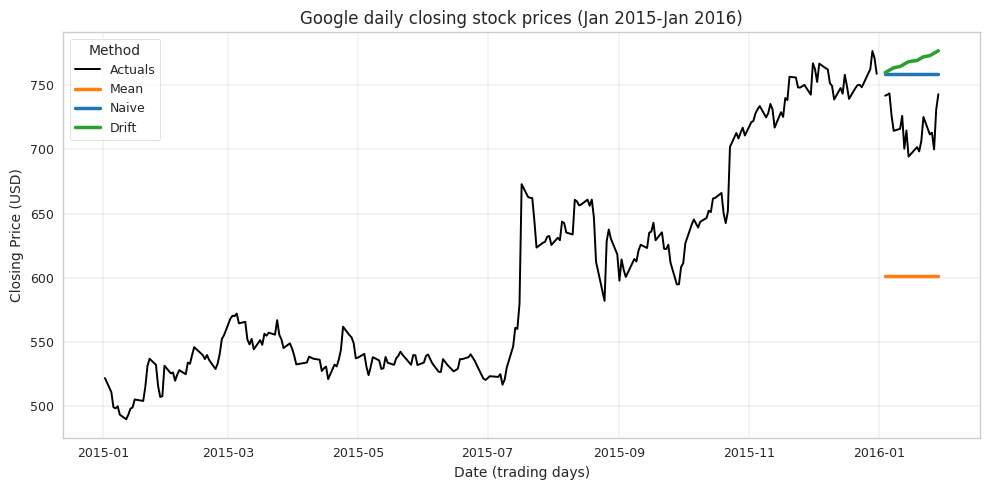

In [36]:
# GOOG daily close in 2015 → non-seasonal forecasts (Mean, Naive, Drift) one month ahead
# Robust to StatsForecast variants where RandomWalkWithDrift column is named 'RWD'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift

# ----------------------------
# Load and subset Google Close
# ----------------------------
df = pd.read_csv("gafa_stock.csv", parse_dates=["ds"])

goog = (
    df.query('unique_id == "GOOG_Close"')
      .loc[:, ["unique_id", "ds", "y"]]
      .sort_values("ds")
      .reset_index(drop=True)
)

# ----------------------------
# Training window: 2015 trading days
# ----------------------------
train = goog.query('ds >= "2015-01-01" and ds <= "2015-12-31"').reset_index(drop=True)
if train.empty:
    raise ValueError("No GOOG_Close observations in 2015.")
last_train_date = train["ds"].max()

# Horizon: trading days in the next calendar month (after last training day)
next_month_end = last_train_date + MonthEnd(1)
future_dates = goog.loc[(goog["ds"] > last_train_date) & (goog["ds"] <= next_month_end), "ds"].tolist()
if len(future_dates) == 0:  # fallback if needed
    future_dates = goog.loc[goog["ds"] > last_train_date, "ds"].head(21).tolist()
h = len(future_dates)

# ----------------------------
# Trading-day index for StatsForecast (freq=1)
# ----------------------------
train_idx = train.copy()
train_idx["ds"] = np.arange(len(train_idx), dtype=int)  # 0..N-1

# ----------------------------
# Models and forecast
# ----------------------------
avg_method   = HistoricAverage()
naive_method = Naive()
drift_method = RandomWalkWithDrift()

sf = StatsForecast(models=[drift_method, avg_method, naive_method], freq=1)
fcasts = sf.forecast(df=train_idx, h=h)  # columns: unique_id, ds, <drift>, HistoricAverage, Naive

# Map forecast step index back to real trading dates
fcasts_plot = fcasts.copy()
fcasts_plot["ds"] = future_dates[:len(fcasts_plot)]

# ----------------------------
# Robust rename of model columns
# ----------------------------
rename = {}
for c in fcasts_plot.columns:
    if c in ("unique_id", "ds"):
        continue
    lc = c.lower()
    if ("randomwalkwithdrift" in lc) or ("rw" in lc and "d" in lc) or (lc == "rwd") or ("drift" in lc):
        rename[c] = "Drift"
    elif "historicaverage" in lc or lc == "mean":
        rename[c] = "Mean"
    elif lc == "naive":
        rename[c] = "Naive"
fcasts_plot = fcasts_plot.rename(columns=rename)

# If a short alias like 'RWD' remains unmapped, catch it
if "Drift" not in fcasts_plot.columns:
    drift_like = [c for c in fcasts_plot.columns if c not in ("unique_id", "ds", "Mean", "Naive")]
    if drift_like:
        fcasts_plot = fcasts_plot.rename(columns={drift_like[0]: "Drift"})

# Actuals within the forecast month (for comparison)
actual_future = goog.loc[goog["ds"].isin(future_dates)].copy()

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 5))

# Actuals (2015 train + next month)
ax.plot(train["ds"], train["y"], color="black", linewidth=1.4, label="Actuals")
if not actual_future.empty:
    ax.plot(actual_future["ds"], actual_future["y"], color="black", linewidth=1.4)

# Forecast lines (distinct colors)
if "Mean" in fcasts_plot:
    ax.plot(fcasts_plot["ds"], fcasts_plot["Mean"],  color="tab:orange", linewidth=2.5, label="Mean")
if "Naive" in fcasts_plot:
    ax.plot(fcasts_plot["ds"], fcasts_plot["Naive"], color="tab:blue",   linewidth=2.5, label="Naive")
if "Drift" in fcasts_plot:
    ax.plot(fcasts_plot["ds"], fcasts_plot["Drift"], color="tab:green",  linewidth=2.5, label="Drift")

ax.set_title("Google daily closing stock prices (Jan 2015-Jan 2016)")
ax.set_xlabel("Date (trading days)")
ax.set_ylabel("Closing Price (USD)")
ax.legend(title="Method", loc="best", frameon=True)
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


## Benchmark Role of Simple Forecasting Methods

In some situations, one of these **simple forecasting methods** may provide the **most effective and practical solution** available.

However, in most applications, these methods primarily serve as **benchmark models**.
Any newly developed forecasting technique should be **evaluated against these benchmarks** to confirm its added value.

If a new model does **not outperform** these simple alternatives, it is **not justified for use**, regardless of its complexity.

Establishing such benchmarks ensures that **model development remains grounded in empirical performance** rather than unnecessary sophistication.


# 6 – Forecasting with Decomposition

**Time series decomposition** is often a valuable step in generating accurate forecasts by separating the data into interpretable components.

### **Additive Decomposition**

When an **additive structure** is assumed:

$$
y_t = \hat{S}_t + \hat{A}_t,
$$

where $\hat{A}_t = \hat{T}_t + \hat{R}_t$ represents the **seasonally adjusted component**.

### **Multiplicative Decomposition**

For a **multiplicative structure**:

$$
y_t = \hat{S}_t \hat{A}_t,
$$

where $\hat{A}_t = \hat{T}_t \hat{R}_t$.

> **Source:** Chapter 5 – *“The Forecaster’s Toolbox”* (FPP, Pythonic Way)
> **URL:** [https://otexts.com/fpppy/nbs/05-toolbox.html](https://otexts.com/fpppy/nbs/05-toolbox.html)


### **Forecasting Strategy**

To forecast a decomposed series:

1. **Seasonal Component ($\hat{S}_t$):**

   * Typically assumed to be **stable** or changing **very slowly**.
   * Forecast using a **seasonal naïve method**, i.e., repeating the **last year’s estimated seasonal pattern**.
2. **Seasonally Adjusted Component ($\hat{A}_t$):**

   * Forecast using any **non-seasonal forecasting method**, such as:

     * The **drift method**
     * **Holt’s method** (FPPPY Chapter 8, not covered here)
     * A **non-seasonal ARIMA model** (FPPPY Chapter 9, not covered here)

This combined approach leverages decomposition to isolate stable seasonal patterns while applying more sophisticated forecasting methods to the adjusted trend and remainder components.



## Load additional libraries


In [37]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)

import os
os.environ["NIXTLA_ID_AS_COL"] = "true"

import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)

import random
random.seed(1)

import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)

from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])

from fpppy.utils import plot_series

In [38]:
from IPython.display import Image
from functools import partial
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
# from utilsforecast.losses import rmse, mae, mape as _mape, mase, quantile_loss, mq
from utilsforecast.losses import rmse, mae, mape as _mape, mase, quantile_loss

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.utils import ConformalIntervals
from statsforecast.models import (
    WindowAverage,
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)
from fpppy.models import LinearRegression

## Example: Naïve forecasts of the seasonally adjusted data obtained from an STL decomposition of the total US retail employment.

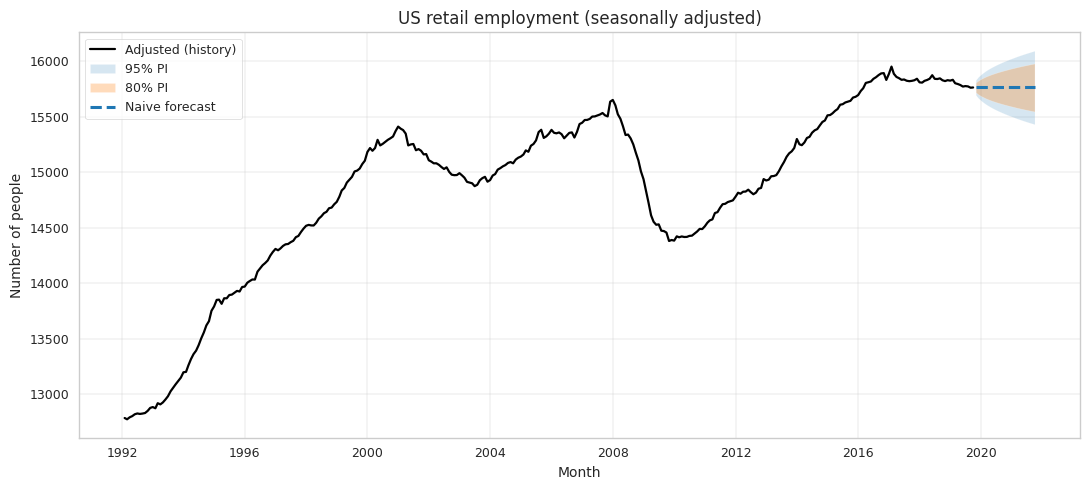

In [70]:
# Seasonally adjust US retail employment, forecast the adjusted series with Naive(),
# and plot with Matplotlib. Fix: pass a *single* 'y' column to StatsForecast
# (avoid duplicate 'y' caused by keeping both raw and adjusted series).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import Naive

# ----------------------------
# Load & filter
# ----------------------------
us_employment_df = pd.read_csv("us_employment_formatted.csv", parse_dates=["ds"])
us_retail_employment_df = (
    us_employment_df.query("Title == 'Retail Trade' and ds.dt.year >= 1992")
    .sort_values("ds")
    .reset_index(drop=True)
    .drop(columns=["Title"])
)

# ----------------------------
# STL seasonal adjustment (monthly -> period=12)
# ----------------------------
stl = STL(us_retail_employment_df["y"].to_numpy(), period=12, robust=True, trend_deg=7)
res = stl.fit()
us_retail_employment_df["seasonal"] = res.seasonal
us_retail_employment_df["y_adjusted"] = (
    us_retail_employment_df["y"] - us_retail_employment_df["seasonal"]
)

# ----------------------------
# Build the dataframe for StatsForecast with a SINGLE 'y' column
# ----------------------------
adj_train = (
    us_retail_employment_df.loc[:, ["unique_id", "ds", "y_adjusted"]]
    .rename(columns={"y_adjusted": "y"})
)

# ----------------------------
# Forecast the seasonally-adjusted series with Naive
# ----------------------------
sf = StatsForecast(models=[Naive()], freq="M")
adj_fc = sf.forecast(df=adj_train, h=24, level=[80, 95], fitted=True)
fitted_vals = sf.forecast_fitted_values()

# Detect model column (e.g., 'Naive')
model_col = next(c for c in adj_fc.columns if c not in ("unique_id", "ds"))

# Optional: rename back for clarity in plotting variables
yhat = adj_fc[model_col]
lo80, hi80 = adj_fc.get(f"{model_col}-lo-80"), adj_fc.get(f"{model_col}-hi-80")
lo95, hi95 = adj_fc.get(f"{model_col}-lo-95"), adj_fc.get(f"{model_col}-hi-95")

# ----------------------------
# Plot with Matplotlib
# ----------------------------
fig, ax = plt.subplots(figsize=(11, 5))

# Historical seasonally-adjusted series
ax.plot(
    us_retail_employment_df["ds"],
    us_retail_employment_df["y_adjusted"],
    color="black",
    linewidth=1.6,
    label="Adjusted (history)",
)

# Prediction intervals (if present)
if lo95 is not None and hi95 is not None:
    ax.fill_between(adj_fc["ds"], lo95, hi95, alpha=0.18, label="95% PI")
if lo80 is not None and hi80 is not None:
    ax.fill_between(adj_fc["ds"], lo80, hi80, alpha=0.28, label="80% PI")

# Point forecast
ax.plot(adj_fc["ds"], yhat, "--", linewidth=2.2, label=f"{model_col} forecast")
sns.set_style("whitegrid")

ax.set_title("US retail employment (seasonally adjusted)")
ax.set_xlabel("Month")
ax.set_ylabel("Number of people")
ax.legend(loc="best", frameon=True)
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


### Forecasting with STL Decomposition

The Figure presents **naïve forecasts** of the **seasonally adjusted US retail employment data**.

These forecasts are then **“reseasonalised”** by adding the **seasonal naïve forecasts** of the seasonal component, effectively reconstructing the full series.

### **Automated Forecasting with `STL()`**

The **`STL()` function** in `statsmodels` simplifies this process by:

* Allowing forecasts from **any additive decomposition**.
* Letting users specify **different forecasting models** for each component.
* Automatically applying **`SeasonalNaive()`** for the seasonal component if no alternative is provided.
* Performing the **reseasonalisation automatically**, ensuring that forecasts of the **original series** are recovered correctly.

The next Figure illustrates the **final reseasonalised forecasts**, showing how the STL framework integrates decomposition and forecasting into a cohesive, automated workflow.


### Example: Forecasts of the total US retail employment data based on a naïve forecast of the seasonally adjusted data and a seasonal naïve forecast of the seasonal component, after an STL decomposition of the data.

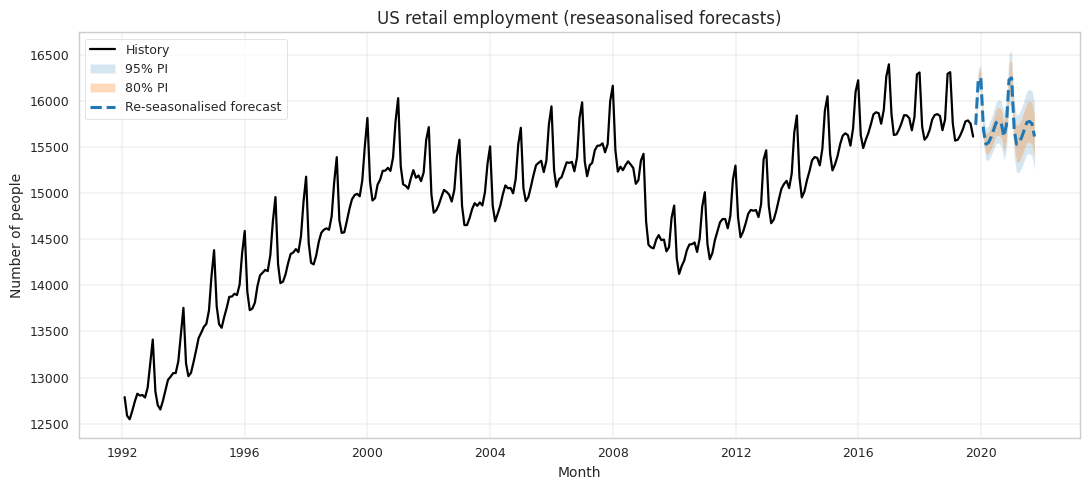

In [71]:
# Re-seasonalise the adjusted forecast by adding a SeasonalNaive forecast of the seasonal component
# and PLOT with Matplotlib.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive   # <-- Naive was missing

# --- helper: keep unique column names (avoids target being returned as a DataFrame) ---
def _dedupe_cols(df: pd.DataFrame) -> pd.DataFrame:
    if df.columns.duplicated().any():
        df = df.loc[:, ~df.columns.duplicated()]
    return df

# 1) Seasonally-adjusted level -> Naive
adj_train = (
    us_retail_employment_df[["unique_id", "ds"]].copy()
    .assign(y=us_retail_employment_df["y_adjusted"])
)
adj_train = _dedupe_cols(adj_train)
adj_train["y"] = pd.to_numeric(adj_train["y"], errors="coerce")
adj_train = adj_train.dropna(subset=["y"])

sf_adj = StatsForecast(models=[Naive()], freq="M")
adjusted_fcasts = sf_adj.forecast(df=adj_train, h=24, level=[80, 95], fitted=True)
adjusted_fcasts_fitted = sf_adj.forecast_fitted_values()

# 2) Seasonal component -> SeasonalNaive
seas_train = (
    us_retail_employment_df[["unique_id", "ds"]].copy()
    .assign(y=us_retail_employment_df["seasonal"])
)
seas_train = _dedupe_cols(seas_train)
seas_train["y"] = pd.to_numeric(seas_train["y"], errors="coerce")
seas_train = seas_train.dropna(subset=["y"])

sf_seas = StatsForecast(models=[SeasonalNaive(season_length=12)], freq="M")
seasonal_fcasts = sf_seas.forecast(df=seas_train, h=24, level=[80, 95], fitted=True)
seasonal_fitted = sf_seas.forecast_fitted_values()

# 3) Combine (re-seasonalise): detect the model-value columns
adj_col = [c for c in adjusted_fcasts.columns if c not in ("unique_id", "ds") and "-lo-" not in c and "-hi-" not in c][0]
sea_col = [c for c in seasonal_fcasts.columns if c not in ("unique_id", "ds") and "-lo-" not in c and "-hi-" not in c][0]

merged = adjusted_fcasts.merge(seasonal_fcasts, on=["unique_id", "ds"], how="inner")
final_df = merged[["unique_id", "ds"]].copy()
final_df["combined"] = merged[adj_col] + merged[sea_col]
for a in (80, 95):
    final_df[f"combined-lo-{a}"] = merged[f"{adj_col}-lo-{a}"] + merged[f"{sea_col}-lo-{a}"]
    final_df[f"combined-hi-{a}"] = merged[f"{adj_col}-hi-{a}"] + merged[f"{sea_col}-hi-{a}"]

# 3b) Residuals (align lengths by merging back, not assigning by position)
merged_fitted = (
    adjusted_fcasts_fitted.merge(seasonal_fitted, on=["unique_id", "ds"], how="inner")
    .merge(us_retail_employment_df[["unique_id", "ds", "y"]], on=["unique_id", "ds"], how="inner")
)
resids = merged_fitted.assign(
    resid = merged_fitted["y"] - merged_fitted[adj_col] - merged_fitted[sea_col]
)[["unique_id", "ds", "resid"]]

# attach residuals (left-join) to the full dataset; rows without fitted values get NaN
us_retail_employment_df = us_retail_employment_df.merge(resids, on=["unique_id", "ds"], how="left")

# 4) Plot with Matplotlib
fig, ax = plt.subplots(figsize=(11, 5))

# History (original, not adjusted)
ax.plot(
    us_retail_employment_df["ds"], us_retail_employment_df["y"],
    color="black", linewidth=1.6, label="History"
)

# Bands
ax.fill_between(
    final_df["ds"], final_df["combined-lo-95"], final_df["combined-hi-95"],
    alpha=0.18, label="95% PI"
)
ax.fill_between(
    final_df["ds"], final_df["combined-lo-80"], final_df["combined-hi-80"],
    alpha=0.28, label="80% PI"
)

# Point forecast
ax.plot(
    final_df["ds"], final_df["combined"],
    "--", linewidth=2.2, label="Re-seasonalised forecast"
)
sns.set_style("whitegrid")
ax.set_title("US retail employment (reseasonalised forecasts)")
ax.set_xlabel("Month")
ax.set_ylabel("Number of people")
ax.legend(loc="best", frameon=True)
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


### Prediction Intervals and Residual Analysis

The **prediction intervals** in this figure above are generated using the **same reseasonalisation process** as the **point forecasts**.

* The **upper and lower bounds** of the intervals for the **seasonally adjusted series** are **reseasonalised** by adding the corresponding **seasonal component forecasts**.

* This ensures that both **point forecasts** and **interval forecasts** reflect the same **seasonal dynamics** of the original data.



### **Residual Diagnostics**

The **ACF of the residuals** (Figure 5.21) reveals **significant autocorrelation**, indicating that:

* The **naïve method** fails to capture the **evolving trend** in the **seasonally adjusted series**.
* This persistence in the residuals suggests that a **more advanced forecasting model** is required to account for the **underlying trend changes** and reduce serial dependence.

A convenient shortcut for producing these residual diagnostic graphs is the plot_diagnostics() function, which will produce a time plot, ACF plot and histogram of the residuals.

In [41]:
def plot_diagnostics(data):
    fig = plt.figure(figsize=(8, 5))

    ax1 = fig.add_subplot(2, 2, (1, 2))
    ax1.plot(data['ds'], data["resid"])
    ax1.set_title("Innovation Residuals")

    ax2 = fig.add_subplot(2, 2, 3)
    plot_acf(data["resid"].dropna(), ax=ax2, zero=False,
             bartlett_confint=False, auto_ylims=True)
    ax2.set_title("ACF Plot")
    ax2.set_xlabel('lag[1]')

    ax3 = fig.add_subplot(2, 2, 4)
    ax3.hist(data["resid"], bins=20)
    ax3.set_title("Histogram")
    ax3.set_xlabel(".resid")
    ax3.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


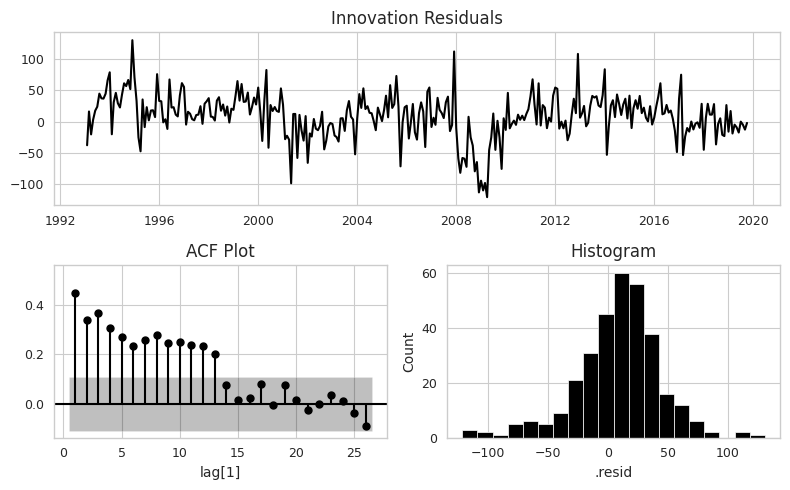

In [42]:
# --- Build a diagnostics-ready training dataframe with residuals ---

# residuals that we already computed on the fitted window
# (keys: ['unique_id','ds','resid'])
# resids = merged_fitted.assign(
#     resid = merged_fitted["y"] - merged_fitted[adj_col] - merged_fitted[sea_col]
# )[["unique_id", "ds", "resid"]]

# keep only training rows (the ones you modeled)
train_df = (
    us_retail_employment_df.loc[:, ["unique_id", "ds", "y"]]   # base training info
    .merge(resids, on=["unique_id", "ds"], how="left")         # attach residuals by key
    .dropna(subset=["resid"])                                  # keep rows that have residuals
    .reset_index(drop=True)
)

# (Optional) make sure types are numeric
train_df["y"] = pd.to_numeric(train_df["y"], errors="coerce")
train_df["resid"] = pd.to_numeric(train_df["resid"], errors="coerce")

# now this has a 'resid' column and will work with your diagnostic plotter
plot_diagnostics(train_df)


# 7 - Evaluating Point Forecast Accuracy

## Training and Test Sets

To properly evaluate **forecast accuracy**, it is essential to assess model performance on **genuine forecasts**, not on the residuals from the fitted model.

Residuals reflect **in-sample fit**, which may underestimate the magnitude of **true forecast errors**. Reliable accuracy assessment requires testing the model on **unseen data**.



### **Data Partitioning for Model Evaluation**

It is standard practice to divide the available data into two segments:

1. **Training Set:**

   * Used to **fit the model** and **estimate parameters**.
2. **Test Set:**

   * Used exclusively to **evaluate forecast performance** on data **not used** during model fitting.

Because the **test data** are withheld from model training, performance metrics calculated on this portion offer a **realistic measure of out-of-sample accuracy** — indicating how well the model generalizes to **future observations**.


### **Data Partitioning for Model Evaluation**

<center>
<div>
<img src="https://raw.githubusercontent.com/davi-moreira/2025F_predictive_analytics_purdue_MGMT474/main/lecture_slides/08_time_series/figs/train_test_split.png" width="1000"/>
</div>
</center>


## Test Set Size and Key Considerations

The **test set** typically represents about **20% of the total sample**, though the exact proportion depends on:

* The **length of the dataset**, and
* The **forecast horizon** of interest.

Ideally, the test set should be **at least as long** as the **maximum forecast horizon** being evaluated.

### **Important Guidelines**

* A model that **fits the training data well** does **not guarantee good forecast performance**.
* A **perfect in-sample fit** can always be achieved with enough parameters — but this leads to **overfitting**.
* **Overfitting** is as detrimental as **underfitting**, as it captures noise rather than genuine patterns.



## Percentage Errors

The **percentage error** is defined as:

$$
p_t = 100 \frac{e_t}{y_t},
$$

where $e_t$ is the forecast error.

Percentage errors are **unit-free**, allowing for easy comparison of forecasting performance across different datasets.



#### **Mean Absolute Percentage Error (MAPE)**

$$
\text{MAPE} = \text{mean}(|p_t|).
$$

**Limitations:**

* Undefined when $y_t = 0$ and unstable when $y_t$ is close to zero.
* Assumes a **meaningful zero point** in the measurement scale (not applicable for temperatures in °C or °F).
* **Penalizes negative errors more heavily** than positive ones.



#### **Symmetric Mean Absolute Percentage Error (sMAPE)**

Proposed by Armstrong (1978):
$$
\text{sMAPE} = \text{mean}\left(200 \frac{|y_t - \hat{y}_t|}{y_t + \hat{y}_t}\right).
$$

However:

* Still unstable for small $y_t$ and $\hat{y}_t$.
* Can produce **negative values**.
* Hyndman and Koehler (2006) **recommend avoiding sMAPE** due to these issues.




## Scaled Errors

To overcome the limitations of percentage errors, **scaled errors** (Hyndman & Koehler, 2006) standardize forecast errors relative to a simple **benchmark method** (typically the naïve forecast).

### **Non-Seasonal Scaled Error**

$$
q_j = \frac{e_j}
{\dfrac{1}{T-1} \sum_{t=2}^{T} |y_t - y_{t-1}| }.
$$

* Independent of the data scale.
* $|q_j| < 1$ indicates a **better forecast** than the average one-step naïve forecast.
* $|q_j| > 1$ indicates a **worse forecast**.




### Scaled Errors for Seasonal Time Series

For **seasonal data**, define the scaled error as:
$$
q_j =
\frac{e_j}
{\dfrac{1}{T - m} \sum_{t = m + 1}^{T} |y_t - y_{t - m}| }.
$$

### **Mean Absolute Scaled Error (MASE)**

$$
\text{MASE} = \text{mean}(|q_j|).
$$

### **Root Mean Squared Scaled Error (RMSSE)**

$$
\text{RMSSE} = \sqrt{\text{mean}(q_j^2)},
$$

where
$$
q_j^2 =
\frac{e_j^2}
{\dfrac{1}{T - m} \sum_{t = m + 1}^{T} (y_t - y_{t - m})^2 }.
$$

For **non-seasonal data**, set $m = 1$.

Scaled errors like **MASE** and **RMSSE** provide **reliable, comparable, and scale-independent** measures of forecast accuracy across different datasets and models.


## Example: Forecasts of Australian quarterly beer production using data up to the end of 2007

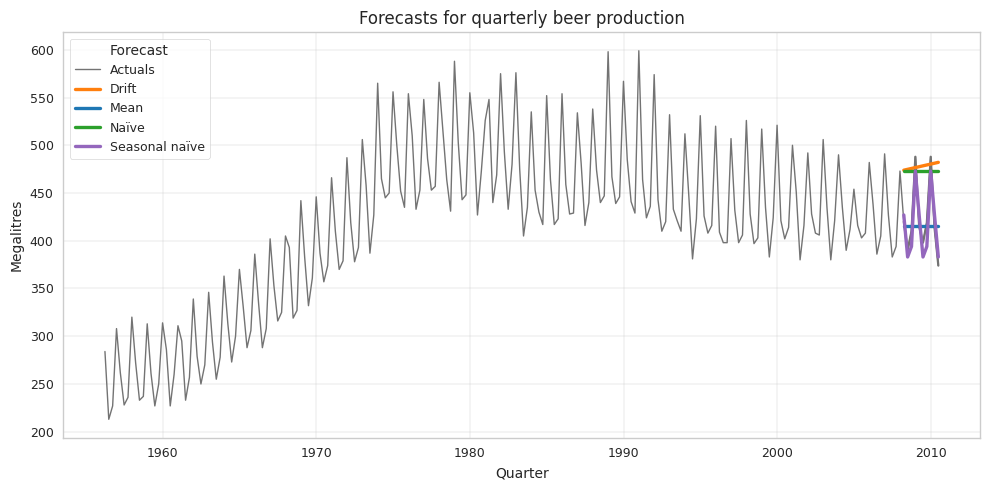

In [43]:
# Forecasts for quarterly beer production (train ≤ 2007; test > 2007)
# Each method plotted with a distinct color. Actuals rendered in gray dashed style.

import matplotlib as mpl
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive

# Ensure default color cycle (in case a global monochrome was set earlier)
mpl.rcParams['axes.prop_cycle'] = mpl.rcParamsDefault['axes.prop_cycle']

beers_df = beer
train_df = beers_df.query("ds.dt.year <= 2007").reset_index(drop=True)
test_df  = beers_df.query("ds.dt.year > 2007").reset_index(drop=True)

mean_method   = HistoricAverage()
naive_method  = Naive()
drift_method  = RandomWalkWithDrift()
seasonal_nav  = SeasonalNaive(season_length=4)

sf = StatsForecast(models=[drift_method, mean_method, naive_method, seasonal_nav], freq="Q")
preds = sf.forecast(df=train_df, h=len(test_df)).reset_index(drop=True)
preds["y_actual"] = test_df["y"].to_numpy()

# Robust mapping from model columns to legend labels
label_map = {
    "RandomWalkWithDrift": "Drift", "RWD": "Drift",
    "HistoricAverage": "Mean",
    "Naive": "Naïve",
    "SeasonalNaive": "Seasonal naïve",
}
# Palette to force non-black method colors
palette = {
    "Drift": "tab:orange",
    "Mean": "tab:blue",
    "Naïve": "tab:green",
    "Seasonal naïve": "tab:purple",
}
model_cols = [c for c in preds.columns if c not in ("unique_id", "ds", "y_actual")]

fig, ax = plt.subplots(figsize=(10, 5))

# Actuals in gray, dashed (applies to full history line)
ax.plot(
    beers_df["ds"], beers_df["y"],
    #color="0.45", linestyle="--", linewidth=1.6, label="Actuals", zorder=1
    color="0.45", linestyle="-", linewidth=1, label="Actuals", zorder=1
)

# Forecasts with explicit colors
for c in model_cols:
    lbl = label_map.get(c, c)
    ax.plot(
        preds["ds"], preds[c],
        linewidth=2.4, color=palette.get(lbl, None), label=lbl, zorder=2
    )

# Optional: overlay test actuals (same gray/dashed, no extra legend entry)
#ax.plot(test_df["ds"], test_df["y"], color="0.45", linestyle="--", linewidth=1.6, zorder=1)
ax.plot(test_df["ds"], test_df["y"], color="0.45", linewidth=1.6, zorder=1)

ax.set_title("Forecasts for quarterly beer production")
ax.set_xlabel("Quarter")
ax.set_ylabel("Megalitres")
ax.legend(title="Forecast", loc="best", frameon=True)
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


### Example: Forecast accuracy measures for the four forecast methods applied to the quarterly Australian beer production

In [44]:
import numpy as np
import pandas as pd

# ----------------------------
# 1) Prepare predictions frame
# ----------------------------
preds_eval = preds.copy()
# Your frame likely has the actuals in 'y_actual'; rename to 'y' if needed
if "y" not in preds_eval and "y_actual" in preds_eval:
    preds_eval = preds_eval.rename(columns={"y_actual": "y"})

# Identify model columns (everything except id/time/actuals)
fixed_cols = {"unique_id", "ds", "y"}
model_cols = [c for c in preds_eval.columns if c not in fixed_cols]

# ----------------------------
# 2) Helper: groupwise metrics
# ----------------------------
def _rmse(y, yhat):
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def _mae(y, yhat):
    return float(np.mean(np.abs(y - yhat)))

def _mape(y, yhat):
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    mask = y != 0
    return float(np.mean(np.abs((y[mask] - yhat[mask]) / y[mask])) * 100.0)

def _mase(y_true, y_hat, y_train, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    MASE = MAE(y_true, y_hat) / MAE of seasonal naive on training set
    """
    y_true = np.asarray(y_true, dtype=float)
    y_hat  = np.asarray(y_hat,  dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    m = int(seasonality)
    if m <= 0 or len(y_train) <= m:
        return np.nan
    denom = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    if denom == 0 or not np.isfinite(denom):
        return np.nan
    return float(np.mean(np.abs(y_true - y_hat)) / denom)

# Pre-compute MASE denominators per series (id)
seasonality = 4  # quarterly; set to 1 for non-seasonal data
train_mae_denom = (
    train_df.sort_values(["unique_id", "ds"])
            .groupby("unique_id", as_index=True)["y"]
            .apply(lambda y: np.mean(np.abs(y.values[seasonality:] - y.values[:-seasonality]))
                   if len(y) > seasonality else np.nan)
            .to_dict()
)

# ----------------------------
# 3) Compute metrics per model
# ----------------------------
rows = []
for model in model_cols:
    # group by series id and aggregate; average (weighted by number of obs) across ids
    per_id = []
    for uid, g in preds_eval.groupby("unique_id"):
        y_true = g["y"].values
        y_hat  = g[model].values
        rmse_i = _rmse(y_true, y_hat)
        mae_i  = _mae(y_true, y_hat)
        mape_i = _mape(y_true, y_hat)
        denom  = train_mae_denom.get(uid, np.nan)
        mase_i = (mae_i / denom) if denom and np.isfinite(denom) else np.nan
        per_id.append((len(g), rmse_i, mae_i, mape_i, mase_i))

    # length-weighted average across ids
    n = sum(k[0] for k in per_id)
    rmse_w = sum(k[0]*k[1] for k in per_id) / n
    mae_w  = sum(k[0]*k[2] for k in per_id) / n
    mape_w = sum(k[0]*k[3] for k in per_id) / n
    mase_w = (sum(k[0]*k[4] for k in per_id if np.isfinite(k[4])) /
              sum(k[0]       for k in per_id if np.isfinite(k[4]))) if any(np.isfinite(k[4]) for k in per_id) else np.nan

    rows.append({"model": model, "rmse": rmse_w, "mae": mae_w, "mape": mape_w, "mase": mase_w})

evaluation = pd.DataFrame(rows).set_index("model").sort_index()
evaluation


,rmse,mae,mape,mase
model,,,,
HistoricAverage,36.484,24.414,5.521,1.543
Naive,62.693,57.400,14.184,3.629
RWD,66.978,60.230,14.938,3.808
SeasonalNaive,14.311,13.400,3.169,0.847


### Evaluating Forecast Accuracy

The **`evaluate()`** function automatically selects the **relevant time periods** from the data (e.g., production values) to align with the corresponding **forecast horizon** when calculating multiple **accuracy metrics**.

### **Comparing Forecasting Methods**

From the analysis:

* The **seasonal naïve method** provides the **best performance** for these data, as clearly shown in the graph.
* Although effective, this method can still be **refined further** for improved accuracy.
* In some cases, **different accuracy measures** may yield **different rankings** of forecasting methods.

  * Here, however, **all measures consistently identify** the **seasonal naïve approach** as the best among the four tested methods.



### Example: Non-Seasonal Example — Google Stock Price

A separate example uses **Google’s daily closing stock prices from 2015**, with **forecasts for January 2016** generated from **three non-seasonal methods**.

The results illustrate how **forecast accuracy evaluation** helps identify which approach best captures short-term market movements in **non-seasonal data**.


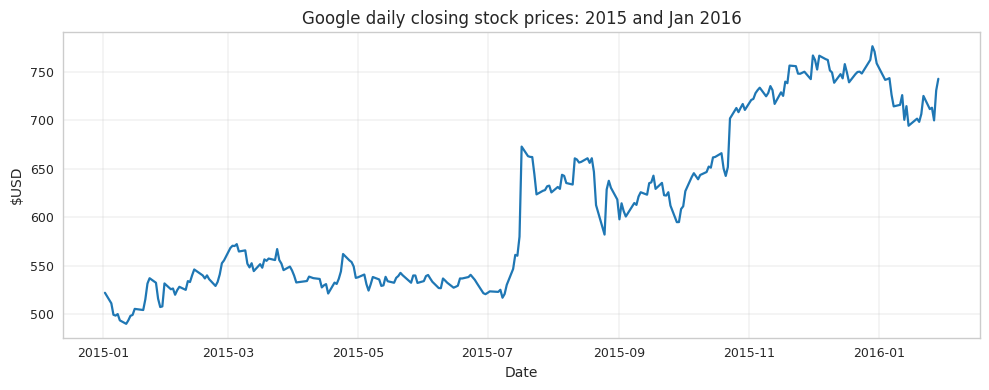

In [45]:
import matplotlib.pyplot as plt

# Select all of 2015 and January 2016 (inclusive)
mask = (goog["ds"] >= "2015-01-01") & (goog["ds"] <= "2016-01-31")
goog_df = goog.loc[mask].sort_values("ds").copy()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(goog_df["ds"], goog_df["y"], linewidth=1.6)
ax.set_title("Google daily closing stock prices: 2015 and Jan 2016")
ax.set_xlabel("Date")
ax.set_ylabel("$USD")
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


### Example: Non-Seasonal Example — Google Stock Price

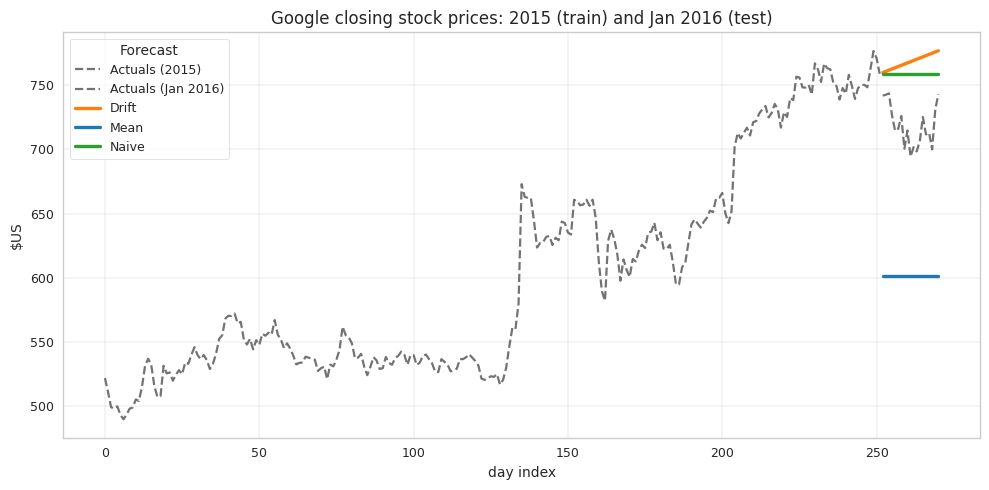

In [46]:
# Google — 2015 train, Jan 2016 test; show forecasts in color (not black)
# Fix: avoid pandas .query with .dt accessors; use boolean masks instead.

import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift

goog_df = goog.loc[(goog["ds"] >= "2015-01-01") & (goog["ds"] <= "2016-01-31")].copy()

# --- Prepare contiguous trading-day index for plotting ---
train_df = (
    goog_df.loc[goog_df["ds"].dt.year == 2015, ["unique_id", "ds", "y"]]
    .reset_index(drop=True)
    .copy()
)
test_df = (
    goog_df.loc[(goog_df["ds"].dt.year == 2016) & (goog_df["ds"].dt.month == 1),
                ["unique_id", "ds", "y"]]
    .reset_index(drop=True)
    .copy()
)

# integer index for StatsForecast
train_df["ds"] = np.arange(len(train_df), dtype=int)
# align test dates right after the training window for plotting/overlay
test_df["ds"] = np.arange(len(train_df), len(train_df) + len(test_df), dtype=int)

# --- Fit models & forecast for the Jan 2016 horizon ---
sf = StatsForecast(models=[RandomWalkWithDrift(), HistoricAverage(), Naive()], freq=1)
preds = sf.forecast(df=train_df, h=len(test_df))

# Add actual Jan 2016 values for reference (optional)
preds = preds.merge(test_df[["unique_id", "ds", "y"]], on=["unique_id", "ds"], how="left")

# Normalize (model) column names across StatsForecast versions
model_cols = [c for c in preds.columns if c not in ("unique_id", "ds", "y")]
rename = {}
for c in model_cols:
    cl = c.lower()
    if cl in ("rwd", "randomwalkwithdrift"): rename[c] = "Drift"
    elif "historicaverage" in cl or cl == "mean": rename[c] = "Mean"
    elif cl == "naive": rename[c] = "Naive"
preds = preds.rename(columns=rename)

# --- Plot (actuals in gray; forecasts in color) ---
fig, ax = plt.subplots(figsize=(10, 5))

# Training and holdout actuals
ax.plot(train_df["ds"], train_df["y"], color="0.45", linestyle="--", linewidth=1.6, label="Actuals (2015)")
ax.plot(test_df["ds"],  test_df["y"],  color="0.45", linestyle="--", linewidth=1.6, label="Actuals (Jan 2016)")

# Colored forecasts
color_map = {"Drift": "tab:orange", "Mean": "tab:blue", "Naive": "tab:green"}
for name, color in color_map.items():
    if name in preds.columns:
        ax.plot(preds["ds"], preds[name], linewidth=2.4, label=name, color=color)

ax.set_title("Google closing stock prices: 2015 (train) and Jan 2016 (test)")
ax.set_xlabel("day index")
ax.set_ylabel("$US")
ax.legend(title="Forecast", loc="best", frameon=True)
ax.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


### Example: Non-Seasonal Example — Google Stock Price

In [47]:
# --- Accuracy table for 2016 holdout (RMSE, MAE, MAPE, MASE) ---

import numpy as np
import pandas as pd

# Keep only the 2016 horizon
h_start, h_end = test_df["ds"].min(), test_df["ds"].max()
holdout = preds.loc[(preds["ds"] >= h_start) & (preds["ds"] <= h_end)].copy()

# Map model display names to whatever column name exists in `preds`
method_columns = {
    "RWD": ["RWD", "RandomWalkWithDrift", "Drift"],
    "HistoricAverage": ["HistoricAverage", "Mean"],
    "Naive": ["Naive"],
}
resolved_cols = {}
for disp, candidates in method_columns.items():
    for c in candidates:
        if c in holdout.columns:
            resolved_cols[disp] = c
            break

# In-sample denominator for MASE (m=1 for daily prices)
y_tr = train_df["y"].to_numpy()
mase_denom = np.mean(np.abs(y_tr[1:] - y_tr[:-1]))

def _rmse(y, yhat):
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def _mae(y, yhat):
    return float(np.mean(np.abs(y - yhat)))

def _mape(y, yhat):
    # guard (not needed for prices, but keeps it robust)
    y_safe = np.where(y == 0, np.nan, y)
    return float(np.nanmean(np.abs((y - yhat) / y_safe)) * 100.0)

rows = []
y_true = holdout["y"].to_numpy()

for disp_name in ["RWD", "HistoricAverage", "Naive"]:
    if disp_name not in resolved_cols:
        continue
    yhat = holdout[resolved_cols[disp_name]].to_numpy()
    mae = _mae(y_true, yhat)
    row = {
        "Method": disp_name,
        "RMSE": _rmse(y_true, yhat),
        "MAE": mae,
        "MAPE": _mape(y_true, yhat),
        "MASE": mae / mase_denom if mase_denom > 0 else np.nan,
    }
    rows.append(row)

acc_df = pd.DataFrame(rows, columns=["Method", "RMSE", "MAE", "MAPE", "MASE"])

# Format to 3 decimals to match the screenshot
acc_df[["RMSE", "MAE", "MAPE", "MASE"]] = acc_df[["RMSE", "MAE", "MAPE", "MASE"]].round(3)

# (Optional) pretty print similar to the attachment
acc_df_style = (
    acc_df.style
    .hide(axis="index")
    .format({"RMSE": "{:.3f}", "MAE": "{:.3f}", "MAPE": "{:.3f}", "MASE": "{:.3f}"})
    .set_table_styles(
        [
            {"selector": "th", "props": [("background-color", "#8c8c8c"), ("color", "white"), ("font-weight", "bold")]},
            {"selector": "td", "props": [("background-color", "#f6f6f6")]}
        ],
        overwrite=False,
    )
)
acc_df, acc_df_style  # display(acc_df_style) in notebooks
display(acc_df_style)

Method,RMSE,MAE,MAPE,MASE
RWD,53.070,49.824,6.992,6.990
HistoricAverage,118.032,116.945,16.235,16.406
Naive,43.432,40.384,5.673,5.666


# 8 – Time Series Cross-Validation

**Time series cross-validation** is a more advanced and reliable approach than the traditional single **training/test split** for evaluating forecasting models.

### **Concept**

* The data are divided into a **sequence of training and test sets**.
* Each **test set** contains **one observation**, and its corresponding **training set** includes **only past observations** — ensuring **no future information leakage**.
* Because accurate forecasts require sufficient historical data, the **earliest observations** are **not used as test cases**.

This iterative approach enables a **comprehensive evaluation** of model performance across multiple forecast origins, providing a **more robust measure of predictive accuracy** for time-dependent data.


### Time Series Cross-Validation

<center>
<div>
<img src="https://raw.githubusercontent.com/davi-moreira/2025F_predictive_analytics_purdue_MGMT474/main/lecture_slides/08_time_series/figs/time_series_cv1.png" width="800"/>
</div>
</center>


### Forecast Accuracy and Rolling Forecasting Origin

The **forecast accuracy** in time series cross-validation is obtained by **averaging the forecast errors** across all **test sets**.

This approach is often referred to as **“evaluation on a rolling forecasting origin”**, because the **forecast origin** — the point from which predictions are made — **moves forward through time**.



### Multi-Step Forecast Evaluation

In many applications, **multi-step forecasts** (e.g., predicting several periods ahead) are more informative than one-step forecasts.
The **rolling-origin cross-validation** method can be extended to evaluate **multi-step errors**, ensuring that performance is measured over the desired forecast horizon.

For instance, if the goal is to assess **4-step-ahead forecast accuracy**, each iteration uses the available data up to time $t$ to forecast up to **$t + 4$**, and errors are computed accordingly — as illustrated in the diagram below.


### Time series cross-validation with multi-step models.

<center>
<div>
<img src="https://raw.githubusercontent.com/davi-moreira/2025F_predictive_analytics_purdue_MGMT474/main/lecture_slides/08_time_series/figs/time_series_cv_multistep.png" width="800"/>
</div>
</center>



### Comparing Residual Accuracy and Cross-Validation Accuracy

In this example, we compare **forecast accuracy** obtained from **time series cross-validation** with that derived from **in-sample residuals**.

The **`cross_validation()`** function is used to generate **multiple training and test sets**, enabling robust out-of-sample evaluation.

Here, the procedure creates **249 validation windows**, each corresponding to **one time step ahead**.
This setup allows for a systematic comparison between:

* **Residual-based accuracy**, which measures in-sample fit, and
* **Cross-validation accuracy**, which evaluates true out-of-sample performance.

Such comparison highlights how **cross-validation provides a more realistic assessment** of forecasting model reliability.


In [48]:
goog_2015 = goog_df.query("ds.dt.year == 2015")
drift_method = RandomWalkWithDrift()

sf = StatsForecast(models=[drift_method], freq="B")
cv_df = sf.cross_validation(h=1, df=goog_2015, step_size=1, test_size=249)

cv_df.head()

,unique_id,ds,cutoff,y,RWD
0,GOOG_Close,2015-01-07,2015-01-06,498.358,487.850
1,GOOG_Close,2015-01-08,2015-01-07,499.929,490.497
2,GOOG_Close,2015-01-09,2015-01-08,493.454,494.427
3,GOOG_Close,2015-01-12,2015-01-09,489.854,487.758
4,GOOG_Close,2015-01-13,2015-01-12,493.464,484.507


### Comparing Residual Accuracy and Cross-Validation Accuracy

The evaluate() function can be used to evaluate the forecast accuracy across the training sets.



In [49]:
from functools import partial
import numpy as np
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import RandomWalkWithDrift
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape, mase

# -------- Data (business-day dates; keep as datetimes) --------
goog_2015 = goog_df.query("ds.dt.year == 2015").copy().sort_values("ds")

# -------- 1) Cross-validation (h=1) --------
sf_cv = StatsForecast(models=[RandomWalkWithDrift()], freq="B")
cv_df = sf_cv.cross_validation(h=1, df=goog_2015, step_size=1, test_size=249)
cv_eval = evaluate(
    cv_df,
    metrics=[rmse, mae, mape, partial(mase, seasonality=1)],
    models=["RWD"],
    train_df=goog_2015,
)

# -------- 2) In-sample 1-step fitted forecasts --------
sf_tr = StatsForecast(models=[RandomWalkWithDrift()], freq="B")
_ = sf_tr.forecast(df=goog_2015, h=1, fitted=True)  # populate fitted store
fitted = sf_tr.forecast_fitted_values()
train_eval = evaluate(
    fitted,
    metrics=[rmse, mae, mape, partial(mase, seasonality=1)],
    models=["RWD"],
    train_df=goog_2015,
)



In [50]:
# Build the "Method / RMSE / MAE / MAPE / MASE" table from evaluate() outputs

def _eval_row(eval_df: pd.DataFrame, label: str, model_col: str = "RWD") -> pd.Series:
    # reshape: rows -> metrics, pick the model column (RWD)
    tmp = (eval_df.set_index("metric")[model_col].astype(float))
    # normalize keys
    tmp.index = tmp.index.str.lower()

    # if MAPE is reported as a fraction, convert to %
    mape_val = tmp.get("mape")
    if pd.notna(mape_val) and mape_val < 1:
        mape_val = mape_val * 100.0

    return pd.Series(
        {
            "Method": label,
            "RMSE":  tmp.get("rmse", np.nan),
            "MAE":   tmp.get("mae",  np.nan),
            "MAPE":  mape_val,
            "MASE":  tmp.get("mase", np.nan),
        }
    )

cv_row    = _eval_row(cv_eval,    "Cross-validation - ['RWD']")
train_row = _eval_row(train_eval, "Training - ['RWD']")

final_tbl = (
    pd.DataFrame([cv_row, train_row])
      .assign(
          RMSE=lambda d: d["RMSE"].round(2),
          MAE =lambda d: d["MAE"].round(2),
          MAPE=lambda d: d["MAPE"].round(2),
          MASE=lambda d: d["MASE"].round(2),
      )[["Method","RMSE","MAE","MAPE","MASE"]]
)

final_tbl


,Method,RMSE,MAE,MAPE,MASE
0,Cross-validation - ['RWD'],11.27,7.26,1.19,1.02
1,Training - ['RWD'],11.15,7.16,1.18,1.00


### Interpreting Forecast Accuracy Results

As expected, **accuracy measures based on residuals** are **smaller** because these “forecasts” are derived from a **model fitted to the entire dataset**, not from genuine out-of-sample predictions.

In contrast, **time series cross-validation** provides a **more realistic evaluation** of model performance on unseen data.

### **Model Selection Criterion**

A reliable strategy for choosing the **best forecasting model** is to select the one with the **lowest Root Mean Squared Error (RMSE)** computed using **time series cross-validation**.

This approach ensures that the selected model generalizes well and performs effectively for **future forecasting scenarios**.


## Example: Forecast Horizon Accuracy with Cross-Validation

The **`google_2015`** subset of the **`gafa_stock`** dataset contains **daily closing stock prices** for **Google Inc.** from the **NASDAQ exchange** throughout **2015**.

In this example, the code evaluates the **forecasting performance** of **drift forecasts** across **1- to 8-step-ahead horizons** using **time series cross-validation**.

Here, **horizons** are the **lead times** we are evaluating—i.e., the number of **business days ahead** each forecast targets, given `freq="B"` and a daily rolling origin.



## Example: Forecast Horizon Accuracy with Cross-Validation

Concretely:

* `h = 1` → next-business-day forecasts (e.g., cutoff 2015-01-06 → predict ds 2015-01-07).
* `h = 2` → two-business-days-ahead forecasts (cutoff t → predict ds t+2B).
* …
* `h = 8` → eight-business-days-ahead forecasts.

For each `h` in `np.arange(1, 9)`, `cross_validation(h=h, step_size=1, test_size=249)` rolls the origin one business day at a time across 2015, computes all **h-step-ahead** predictions with `RandomWalkWithDrift`, and `evaluate(..., metrics=[rmse])` aggregates the RMSE across those folds for that specific horizon. The scatter then plots **RMSE vs. forecast horizon (1–8 business days ahead)**.

The resulting plot demonstrates that **forecast error increases with the forecast horizon**, which is the expected outcome — as **longer-term forecasts** naturally accumulate more **uncertainty** and **modeling error** over time.


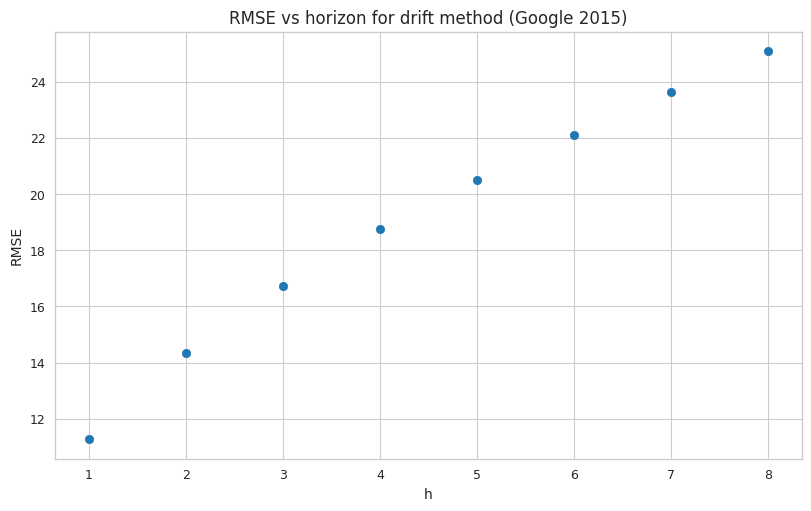

In [51]:
rmses = []
drift_model = RandomWalkWithDrift()
horizons = np.arange(1, 9)

for horizon in horizons:
    sf = StatsForecast(models=[drift_model], freq="B")
    cv_df = sf.cross_validation(h=horizon, df=goog_2015, step_size=1, test_size=249)
    cv_evaluation = evaluate(cv_df, metrics=[rmse], models=["RWD"])
    rmses.append(cv_evaluation["RWD"].iloc[0])

fig, ax = plt.subplots()
ax.scatter(horizons, rmses)
ax.set_xlabel("h")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs horizon for drift method (Google 2015)")
plt.show()

# 9 - End-to-End Workflow

In [52]:
!pip install sktime scikit-learn pandas numpy

In [53]:
# Environment setup and imports.
# Install these locally if missing:
# pip install sktime scikit-learn pandas numpy
import numpy as np
import pandas as pd

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV

np.random.seed(474)


## Synthetic Time Series for Demonstration
We create a simple seasonal signal with noise to illustrate temporal splits, naive baselines, direct/recursive reduction, and rolling backtests.


Synthetic data and seasonal period


* The series is daily and length 400.

* Signal = sinusoid $+;$ noise $+;$ linear trend:
  
  $$
  y_t=\sin(t/12)+0.1,\varepsilon_t+0.01,t,
  $$
  
  which creates a smooth seasonal‐like cycle and a mild upward trend.

* `SP = 75` is the assumed season length (approximately the sinusoid’s cycle in days).



In [54]:
# -----------------------------
# Synthetic data
n = 400
idx = pd.date_range("2015-01-01", periods=n, freq="D")
y = pd.Series(
    np.sin(np.arange(n) / 12.0) + 0.1 * np.random.randn(n) + 0.01 * np.arange(n),
    index=idx,
    name="y",
)

SP = 75  # seasonal period

y.head(), y.tail()



(2015-01-01    0.104
 2015-01-02    0.026
 2015-01-03    0.298
 2015-01-04    0.206
 2015-01-05    0.350
 Freq: D, Name: y, dtype: float64,
 2016-01-31    4.970
 2016-02-01    4.902
 2016-02-02    4.751
 2016-02-03    5.126
 2016-02-04    5.009
 Freq: D, Name: y, dtype: float64)

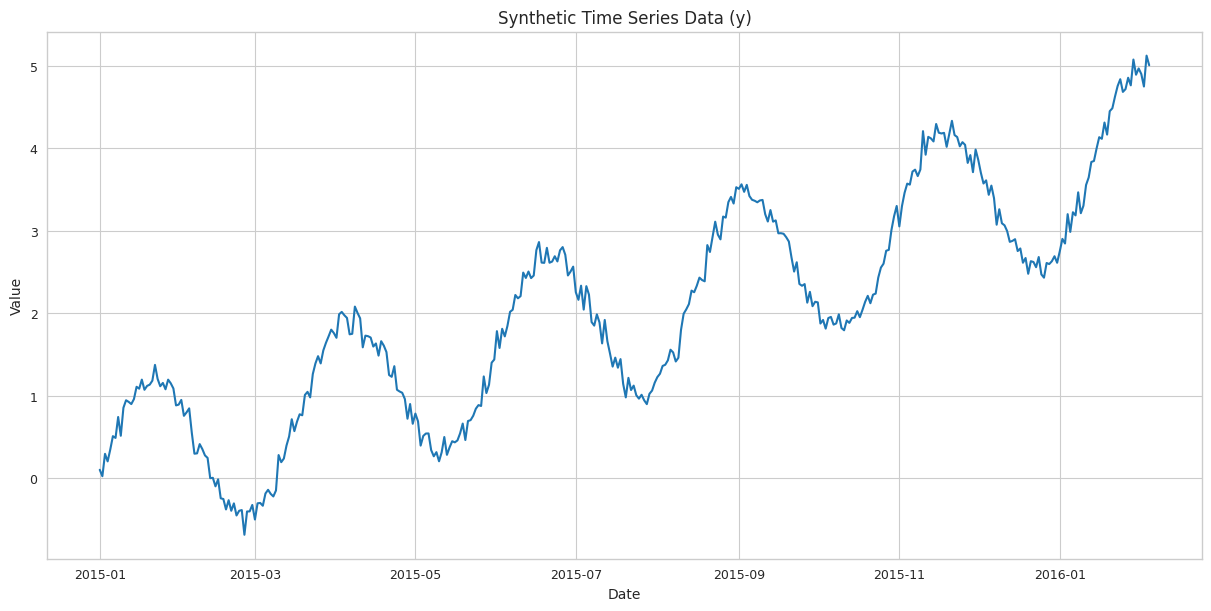

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=y)
plt.title("Synthetic Time Series Data (y)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

## Temporal Split and Naive Benchmark
We use a last-value naive forecaster as a baseline and compute MAPE on a 30-step horizon.


**Goal**
Set up a fair, time-aware test for forecasting. Start with an easy-to-understand baseline (the “last value” forecast) and measure how far off it is using MAPE.

**1) Split by time (no leakage)**

* `temporal_train_test_split(y, test_size=30)` cuts the series into two parts **in order**:
  **train** = everything up to the split; **test** = the last 30 points.
* We never let the model see the test part while training. This prevents **look-ahead bias** (using future info to predict the future).

**2) Tell the model how far ahead to predict (the horizon `fh`)**

* `fh = np.arange(1, len(y_test) + 1)` creates the steps we want: 1, 2, …, 30 days ahead.
* This is a **relative horizon**: “from the last training day, predict 1 step ahead, then 2, …”. It works regardless of whether the index is dates or simple integers.

**3) Baseline forecast: “last value”**

* `NaiveForecaster(strategy="last")` always predicts the **last value from the training set** for every future step.
* `fit(y_train)` just remembers that last value; no parameters are learned.
* `predict(fh)` returns a flat line (same number repeated for all 30 steps).
* Why use it? It’s a **sanity check**. If a fancy model can’t beat this, it’s not adding value.

**4) How we score it: MAPE**

* `mean_absolute_percentage_error(y_test, y_pred_last)` computes
  MAPE = average of $|y_t - \hat y_t| / |y_t| \times 100%$.
* Interpretation: on average, how many percent off are our forecasts on the 30 test points?
* Caution: if any true value is 0 (or very close), MAPE can blow up. In those cases also report MAE or RMSE, or use sMAPE.

**5) Why this setup matters**

* **Fairness**: time-ordered split avoids peeking into the future.
* **Benchmarking**: gives a clear bar to beat (`mape_last`).
* **Reproducibility**: explicit horizon + explicit metric = results others can replicate.

**6) Helpful variations**

* **Seasonal data**: `NaiveForecaster(strategy="seasonal_last", sp=m)` uses the last value from the same season (e.g., same month last year if `m=12`).
* **Trend**: `strategy="drift"` extrapolates a straight line from the first to the last training points.
* **Diagnostics**: check error **by step ahead** (1-step vs 30-step) to see where accuracy decays.

**Bottom line**
You build a clean time-based test, create a simple carry-forward forecast, and compute its MAPE. Any model you try next must deliver a **lower MAPE** than this baseline to be worth using.


In [56]:
# Temporal split
y_train, y_test = temporal_train_test_split(y, test_size=30)
fh = np.arange(1, len(y_test) + 1)  # forecast horizon steps ahead

# Naive benchmark
f_last = NaiveForecaster(strategy="last")
f_last.fit(y_train)
y_pred_last = f_last.predict(fh)

mape_last = mean_absolute_percentage_error(y_test, y_pred_last)
mape_last


np.float64(0.2887089356544459)

In [57]:
y_train.tail()

,y
2016-01-01,2.753
2016-01-02,2.904
2016-01-03,2.848
2016-01-04,3.204
2016-01-05,2.989


In [58]:
y_test.head()

,y
2016-01-06,3.227
2016-01-07,3.189
2016-01-08,3.468
2016-01-09,3.215
2016-01-10,3.306


In [59]:
y_pred_last.head()

,y
2016-01-06,2.989
2016-01-07,2.989
2016-01-08,2.989
2016-01-09,2.989
2016-01-10,2.989


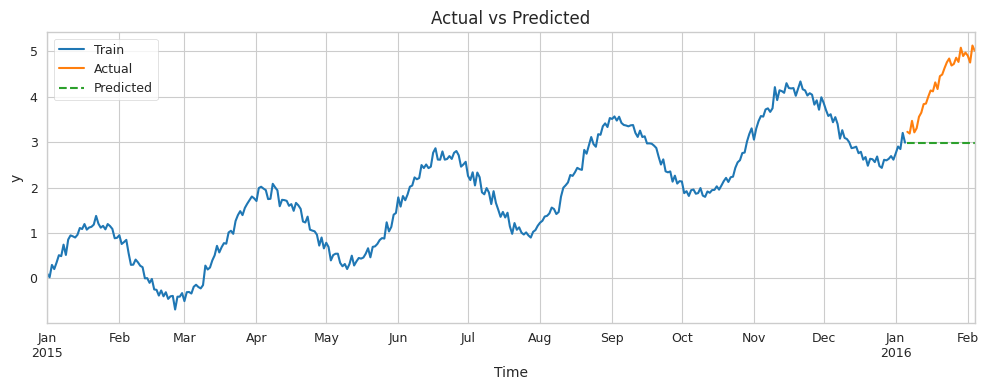

In [60]:
# Actual vs Predicted time series plot

import pandas as pd
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

# Ensure forecast is indexed on the test horizon (safe for any forecaster)
y_pred_last = pd.Series(y_pred_last, index=y_test.index, name="Predicted")

# Pure matplotlib
fig, ax = plt.subplots(figsize=(10, 4))
y_train.plot(ax=ax, label="Train")
y_test.plot(ax=ax, label="Actual")
y_pred_last.plot(ax=ax, label="Predicted", linestyle="--")
ax.set_title("Actual vs Predicted")
ax.set_xlabel("Time")
ax.set_ylabel("y")
ax.legend()
plt.tight_layout()
plt.show()



## Theta forecasting model

The code fits a **Theta** forecasting model (without deseasonalizing) and compares it to a **naïve** baseline using **MAPE** on a held-out test window. It avoids “multiplicative seasonality” because the series can take zero/negative values (multiplicative seasonal models require strictly positive data).

---

### Key objects assumed from earlier cells

* `y_train`, `y_test`: time-ordered split of the original series (`y`), typically produced by `temporal_train_test_split`.
* `fh`: the **forecasting horizon**, e.g., `fh = [1,2,…,H]`, indicating how many steps ahead to predict from the end of `y_train`.
* `y_pred_last`, `mape_last`: predictions and MAPE from the naïve benchmark (carry-forward “last value”).

**Why split by time?**
We must preserve ordering to avoid look-ahead bias. Training uses only past data; evaluation is on future points.

---

### Baseline metric: MAPE

The mean absolute percentage error is

$$
\text{MAPE} = \frac{100%}{H}\sum_{h=1}^{H}\left|\frac{y_{T+h}-\hat y_{T+h}}{y_{T+h}}\right|,
$$

where:

* $T$ = last index in the training set,
* $H = |fh|$ = number of forecast steps,
* $y_{T+h}$ = actual value (h) steps ahead,
* $\hat{y}_{T+h}$ = forecast.

Lower is better. MAPE becomes unstable if any (y_{T+h}\approx 0).

---

### Why “multiplicative seasonality” is problematic here

A seasonal component can enter a model **additively** or **multiplicatively**:

* Additive: $y_t = \text{level}_t + \text{trend}_t + s_t + \varepsilon_t$
* Multiplicative: $y_t = \text{level}_t \times \text{trend}_t \times s_t \times (1+\varepsilon_t)$

Multiplicative seasonality needs strictly positive (y_t). If the series can be zero/negative (common after centering or with noise), statsmodels raises the error you saw. The code therefore **does not** use multiplicative deseasonalization.

---

### Model A — ThetaForecaster (no deseasonalization)

```python
theta = ThetaForecaster(sp=1, deseasonalize=False)
theta.fit(y_train)
y_pred_theta = theta.predict(fh)
mape_theta = mean_absolute_percentage_error(y_test, y_pred_theta)
```

**What is the Theta method?**
The Theta method (Assimakopoulos & Nikolopoulos, 2000) modifies the local curvature of the series by applying **theta lines** to the second differences. It blends two extrapolations:

1. A **local level/trend** component (similar to Simple Exponential Smoothing with drift),
2. A **long-term mean reversion** component.

A useful way to view Theta is its equivalence (under conditions) to **SES with drift** (Hyndman & Billah, 2003):

* SES update:

  $$
  \ell_t = \alpha y_t + (1-\alpha)\ell_{t-1}
  $$

* (h)-step forecast with drift:
  
  $$
  \hat y_{t+h|t} = \ell_t + d\cdot h,
  $$

  where (d) is a data-driven drift term capturing trend.

Setting `sp=1` tells `ThetaForecaster` that there is **no seasonal period** to remove internally. `deseasonalize=False` ensures the model does **not** attempt multiplicative/seasonal decomposition (the source of the earlier error). The forecaster then extrapolates level + trend only.

**Intuition:**

Theta smooths the series to estimate a stable current level and a gentle slope, then projects that slope forward. It’s robust for many series with mild trends.

---

### Comparing models and choosing the winner

```python
print({"MAPE_last": float(mape_last), "MAPE_theta": float(mape_theta)})

best_name, best_mape, best_pred = min(
    [("naive", mape_last, y_pred_last), ("theta_nodeseason", mape_theta, y_pred_theta)],
    key=lambda x: x[1]
)
print({"best_model": best_name, "best_mape": float(best_mape)})
```

* We report the baseline error (`MAPE_last`) and Theta’s error (`MAPE_theta`).
* We select the model with the **lower** MAPE. If Theta < naïve, we have demonstrated value over a trivial benchmark.

---

### Where ETS fits conceptually (mentioned in comments)

Although not executed in this snippet, **Exponential Smoothing (ETS)** models combine:

* **Error** type (additive/multiplicative),
* **Trend** (none/additive/damped),
* **Seasonality** (none/additive/multiplicative) with period (s).

A common additive ETS specification is:

$$
\begin{aligned}
y_t &= \ell_{t-1} + b_{t-1} + s_{t-s} + \varepsilon_t,\
\ell_t &= \ell_{t-1} + b_{t-1} + \alpha \varepsilon_t,\
b_t &= b_{t-1} + \beta \varepsilon_t,\
s_t &= s_{t-s} + \gamma \varepsilon_t,
\end{aligned}
$$

with smoothing parameters (\alpha,\beta,\gamma \in (0,1)). ETS is appropriate for additive seasonality and can complement Theta by explicitly modeling seasonal cycles.

---

### Practical checklist

1. **Always** build a naïve baseline and compute its MAPE.
2. Use time-ordered splits and an explicit horizon.
3. If your series can be zero/negative, **avoid multiplicative seasonality**. Prefer additive seasonality or set `sp=1` and handle trend only.
4. Compare models on the **same** horizon and **same** test window.
5. Visualize actuals vs. forecasts and inspect step-ahead errors to understand where accuracy degrades.

**Takeaway:** the code fits a trend-focused Theta model that sidesteps multiplicative-seasonality restrictions, evaluates it with MAPE on a proper time split, and programmatically selects the better performer relative to the naïve standard.


In [61]:
# Robust alternative that avoids the multiplicative-seasonality error.
# Use non-deseasonalized Theta (trend-focused) plus ETS with additive seasonality.

import numpy as np
import pandas as pd

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# ----- Model A: Theta without internal deseasonalization (avoids multiplicative issue) -----
# Focuses on level/trend; we'll let ETS handle seasonality.
theta = ThetaForecaster(sp=1, deseasonalize=False)
theta.fit(y_train)
y_pred_theta = theta.predict(fh)
mape_theta = mean_absolute_percentage_error(y_test, y_pred_theta)

print({
    "MAPE_last": float(mape_last),
    "MAPE_theta": float(mape_theta),
})

# Choose the better of the two candidate models
best_name, best_mape, best_pred = min(
    [("naive", mape_last, y_pred_last), ("theta_nodeseason", mape_theta, y_pred_theta)],
    key=lambda x: x[1]
)
print({"best_model": best_name, "best_mape": float(best_mape)})


{'MAPE_last': 0.2887089356544459, 'MAPE_theta': 0.2658110643420696}
{'best_model': 'theta_nodeseason', 'best_mape': 0.2658110643420696}


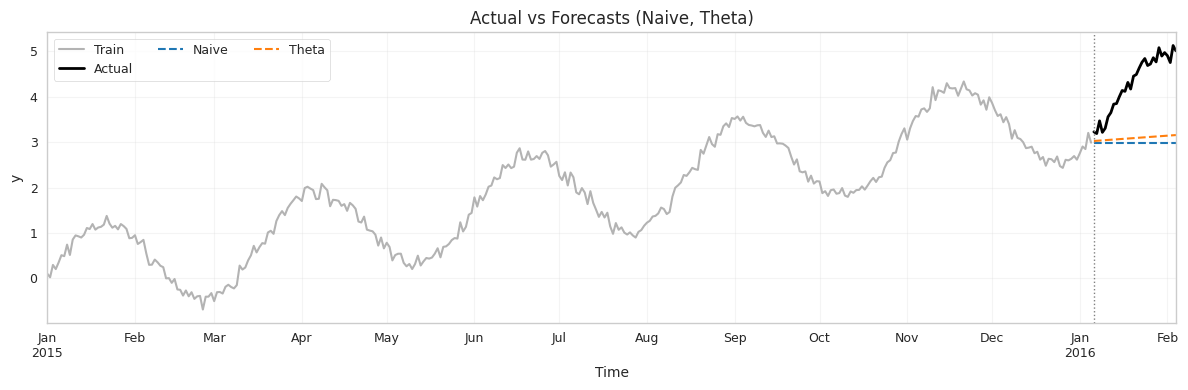

In [62]:
# Plot actuals and forecasts (naive, theta, ETS) with distinct colors/styles

import pandas as pd
import matplotlib.pyplot as plt

# Ensure all forecasts are Series aligned to the test index
y_pred_last  = pd.Series(y_pred_last,  index=y_test.index, name="Naive")
y_pred_theta = pd.Series(y_pred_theta, index=y_test.index, name="Theta")

fig, ax = plt.subplots(figsize=(12, 4))

# Actuals
y_train.plot(ax=ax, color="0.7", label="Train")
y_test.plot(ax=ax, color="black", linewidth=2, label="Actual")

# Predictions
y_pred_last.plot(ax=ax,  color="#1f77b4", linestyle="--", label="Naive")
y_pred_theta.plot(ax=ax, color="#ff7f0e", linestyle="--", label="Theta")

# Split marker
ax.axvline(y_test.index[0], color="0.5", linestyle=":", linewidth=1)

ax.set_title("Actual vs Forecasts (Naive, Theta)")
ax.set_xlabel("Time")
ax.set_ylabel("y")
ax.legend(loc="best", ncols=3)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


## Exponential Smoothing (ETS) model

**What this code does**
Fits an Exponential Smoothing (ETS) model with **additive trend** and **additive seasonality** to the training data, generates multi-step forecasts for the test horizon, evaluates accuracy with MAPE, and programmatically selects the better model between **Theta** and **ETS** based on the lower MAPE.

---

### Why ETS here

The data have a smooth sinusoidal pattern (seasonality) plus a slow upward drift (trend). ETS explicitly models **level**, **trend**, and **seasonality** with exponential smoothing updates. The configuration

```python
ExponentialSmoothing(trend="add", seasonal="add", sp=75, damped_trend=True)
```

means:

* **trend="add"**: an **additive** trend component ($+$ slope).
* **seasonal="add"**: **additive** seasonal pattern (appropriate when seasonal amplitude does not scale with the level).
* **sp=75**: seasonal period of 75 time steps (daily data with a ~75-day cycle).
* **damped_trend=True**: trend impact decays over the forecast horizon via a damping factor $\phi \in (0,1)$, preventing unrealistic runaway growth.

---

### The ETS(A,A,A) with damping: state-space equations

An additive error/additive trend/additive seasonality model with damping (often denoted ETS(A,Ad,A)) has latent states:

* Level: $\ell_t$
* Trend (slope): $b_t$
* Seasonality: $s_t$ with period $s=\text{sp}$

**Observation (data) equation**
$$
y_t = \ell_{t-1} + \phi b_{t-1} + s_{t-s} + \varepsilon_t,
$$
where $\varepsilon_t$ is the one-step-ahead error.

**State update equations**
$$
\ell_t = \ell_{t-1} + \phi b_{t-1} + \alpha \varepsilon_t,
$$
$$
b_t = \phi b_{t-1} + \beta \varepsilon_t,
$$
$$
s_t = s_{t-s} + \gamma \varepsilon_t,
$$
with smoothing parameters $\alpha,\beta,\gamma \in (0,1)$ estimated from the data, and damping $\phi \in (0,1)$.

**$h$-step-ahead forecast** (produced by `predict(fh)`)
$$
\hat y_{t+h|t} = \ell_t + \left(\sum_{j=1}^{h} \phi^j\right) b_t + s_{t+h-s\left\lfloor\frac{h-1}{s}\right\rfloor}.
$$
When $\phi<1$, the contribution of the trend term $\sum_{j=1}^{h}\phi^j$ tapers off as $h$ increases (damped trend).

**Additive vs. multiplicative**

* *Additive* seasonality adds a fixed seasonal effect: $+,s_{t-s}$.
* *Multiplicative* seasonality scales with level: $\times,s_{t-s}$ (requires strictly positive values; not used here).

---

### Fit, forecast, and horizon

```python
ets.fit(y_train)
y_pred_ets = ets.predict(fh)
```

* `fit(y_train)` estimates $\alpha,\beta,\gamma,\phi$ and initializes $\ell_t, b_t, s_t$ using only the training portion (no leakage).
* `fh` is the **forecasting horizon** (e.g., steps 1…30 ahead from the training endpoint). `predict(fh)` produces the corresponding vector ${\hat y_{T+1|T},\dots,\hat y_{T+H|T}}$.

---

### Accuracy metric: MAPE

```python
mape_ets = mean_absolute_percentage_error(y_test, y_pred_ets)
```

Mean Absolute Percentage Error:
$$
\text{MAPE} = \frac{100%}{H}\sum_{h=1}^{H}\left|\frac{y_{T+h}-\hat y_{T+h}}{y_{T+h}}\right|.
$$

* Interprets error in percent terms (lower is better).
* Be careful when $y_{T+h}$ is zero or very small (instability).

The printout compares:

```python
{"MAPE_last": ..., "MAPE_theta": ..., "MAPE_ets": ...}
```

* **MAPE_last**: naïve baseline (carry the last value forward).
* **MAPE_theta**: Theta model (trend-focused, no seasonality).
* **MAPE_ets**: ETS with additive trend/seasonality and damping.

---

### Model selection by metric

```python
best_name, best_mape, best_pred = min(
    [("theta_nodeseason", mape_theta, y_pred_theta), ("ets_add", mape_ets, y_pred_ets)],
    key=lambda x: x[1]
)
```

* Builds a small leaderboard of candidates with their MAPE.
* `min(..., key=lambda x: x[1])` picks the tuple with the smallest second element (the MAPE).
* Returns the **name**, **score**, and **predictions** of the winner for downstream use.

---

### Practical intuition

* **ETS learns three moving pieces**: today’s baseline level, the slope of change, and a repeating seasonal pattern.
* **Additive seasonality** says “add a seasonal bump” rather than “scale by a seasonal factor,” which is safer when values can be near zero or negative.
* **Damped trend** avoids forecasts that grow too fast by shrinking the trend effect step by step with $\phi^h$.
* The selected model must **beat the naïve MAPE** to justify its complexity on this dataset.


In [63]:
# ----- Model B: ETS with additive trend/seasonality (handles sine + trend) -----
ets = ExponentialSmoothing(trend="add", seasonal="add", sp=75, damped_trend=True)
ets.fit(y_train)
y_pred_ets = ets.predict(fh)
mape_ets = mean_absolute_percentage_error(y_test, y_pred_ets)

print({
    "MAPE_last": float(mape_last),
    "MAPE_theta": float(mape_theta),
    "MAPE_ets": float(mape_ets),
})

# Choose the better of the two candidate models
best_name, best_mape, best_pred = min(
    [("theta_nodeseason", mape_theta, y_pred_theta), ("ets_add", mape_ets, y_pred_ets)],
    key=lambda x: x[1]
)
print({"best_model": best_name, "best_mape": float(best_mape)})


{'MAPE_last': 0.2887089356544459, 'MAPE_theta': 0.2658110643420696, 'MAPE_ets': 0.03130788494131025}
{'best_model': 'ets_add', 'best_mape': 0.03130788494131025}


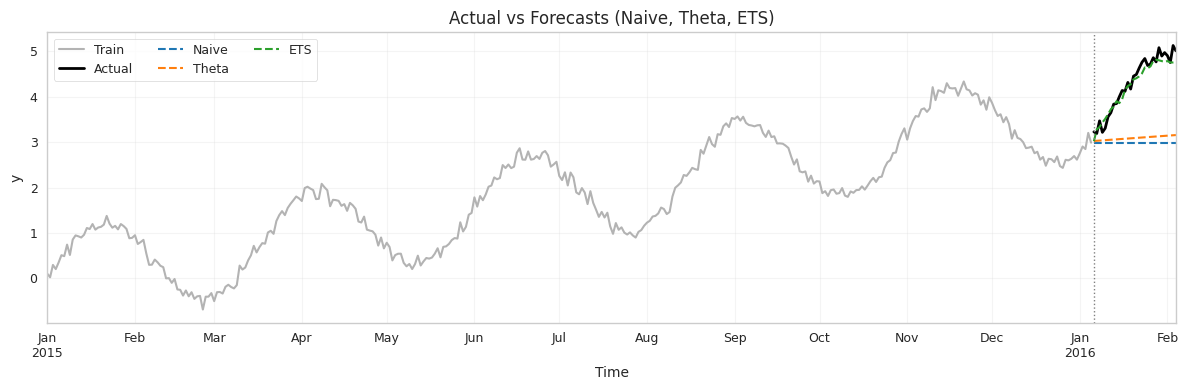

In [64]:
# Plot actuals and forecasts (naive, theta, ETS) with distinct colors/styles

import pandas as pd
import matplotlib.pyplot as plt

# Ensure all forecasts are Series aligned to the test index
y_pred_last  = pd.Series(y_pred_last,  index=y_test.index, name="Naive")
y_pred_theta = pd.Series(y_pred_theta, index=y_test.index, name="Theta")
y_pred_ets   = pd.Series(y_pred_ets,   index=y_test.index, name="ETS")

fig, ax = plt.subplots(figsize=(12, 4))

# Actuals
y_train.plot(ax=ax, color="0.7", label="Train")
y_test.plot(ax=ax, color="black", linewidth=2, label="Actual")

# Predictions
y_pred_last.plot(ax=ax,  color="#1f77b4", linestyle="--", label="Naive")
y_pred_theta.plot(ax=ax, color="#ff7f0e", linestyle="--", label="Theta")
y_pred_ets.plot(ax=ax,   color="#2ca02c", linestyle="--", label="ETS")

# Split marker
ax.axvline(y_test.index[0], color="0.5", linestyle=":", linewidth=1)

ax.set_title("Actual vs Forecasts (Naive, Theta, ETS)")
ax.set_xlabel("Time")
ax.set_ylabel("y")
ax.legend(loc="best", ncols=3)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


## Time-Series Cross Validation

Evaluate and compare three forecasters—Naive, Theta, and ETS—using **time-series cross-validation** (rolling/forward-chaining). The code also records, for every fold, the **calendar dates** used in training and testing, computes fold-level errors, and summarizes performance.

---

### Time-series cross-validation (rolling origin)

```python
cv = SlidingWindowSplitter(window_length=180, fh=np.arange(1, 31), step_length=7)
```

* **Training window**: last 180 observations before each cutoff.
* **Forecasting horizon**: `fh = 1..30` means produce 30-step-ahead forecasts from each cutoff.
* **Step length**: move the cutoff forward **7** observations at a time (weekly).
* This is leakage-free because each fold trains on past data and tests on strictly future data.

**Absolute vs. relative horizon.** Later, each fold converts `fh` to **absolute** timestamps so forecasts align to the calendar:

```python
fh_abs = ForecastingHorizon(y.index[test_idx], is_relative=False)
```

---

### Calendar of folds (what dates were used)

```python
fold_meta = []
for fold_id, (tr_idx, te_idx) in enumerate(cv.split(y), start=1):
    fold_meta.append({
        "fold": fold_id,
        "train_start": y.index[tr_idx[0]],
        "train_end":   y.index[tr_idx[-1]],
        "test_start":  y.index[te_idx[0]],
        "test_end":    y.index[te_idx[-1]],
        "n_train":     len(tr_idx),
        "n_test":      len(te_idx),
    })
cv_folds_calendar = pd.DataFrame(fold_meta)
```

* For each fold, the code stores the **train and test start/end dates** and counts.

* This table documents the rolling windows used in CV—critical for auditability.

---

### Candidate forecasters

```python
models = {
    "naive_last": NaiveForecaster(strategy="last"),
    "theta_nodeseason": ThetaForecaster(sp=1, deseasonalize=False),
    "ets_add": ExponentialSmoothing(
        trend="add", seasonal="add", sp=SP, damped_trend=True,
        initialization_method="estimated"
    ),
}
```

* **Naive (last)**: $\hat y_{t+h|t}=y_t$ for all $h$.

* **Theta (no deseasonalization)**: trend-focused extrapolation (related to SES with drift), robust when values may be near zero since no multiplicative seasonality is applied.

* **ETS(A,Ad,A)**: additive error, **additive** trend (damped), **additive** seasonality with period $s=SP$. State-space form:

  Observation:
  
  $$
  y_t=\ell_{t-1}+\phi b_{t-1}+s_{t-s}+\varepsilon_t
  $$

  Updates:
  
  $$
  \ell_t=\ell_{t-1}+\phi b_{t-1}+\alpha\varepsilon_t,\quad
  b_t=\phi b_{t-1}+\beta\varepsilon_t,\quad
  s_t=s_{t-s}+\gamma\varepsilon_t,
  $$
  
  with $\alpha,\beta,\gamma\in(0,1)$ and damping $\phi\in(0,1)$.

  $h$-step forecast:
  
  $$
  \hat y_{t+h|t}=\ell_t+\Big(\sum_{j=1}^{h}\phi^j\Big)b_t+s_{t+h-s\lfloor (h-1)/s\rfloor}.
  $$

* `initialization_method="estimated"` lets the model estimate initial level/trend/seasonals rather than relying on heuristic rules requiring two full seasonal cycles.

---

### Cross-validated backtest routine

```python
def cv_backtest(y, forecaster, cv):
    preds_list, ape_records, fold_scores = [], [], []
    for fold_id, (train_idx, test_idx) in enumerate(cv.split(y), start=1):
        y_train, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        fh_abs = ForecastingHorizon(y.index[test_idx], is_relative=False)

        f = clone(forecaster)    # fresh copy per fold
        f.fit(y_train)           # learn only from the current training window
        y_pred_fold = f.predict(fh=fh_abs)

        preds_list.append(y_pred_fold)

        # Fold-level error: MAPE
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold)
        fold_scores.append({"fold": fold_id, "MAPE": float(mape_fold)})

        # Pointwise errors for diagnostics: APE = |y - ŷ| / |y|
        ape = (y_test_fold - y_pred_fold).abs() / y_test_fold.abs()
        for t, val in ape.items():
            ape_records.append({"time": t, "APE": float(val), "fold": fold_id})

    # “Stitched” predictions across folds (later folds overwrite overlaps)
    preds = pd.concat(preds_list).sort_index()
    preds = preds[~preds.index.duplicated(keep="last")]
    return preds, pd.DataFrame(fold_scores), pd.DataFrame(ape_records)
```

* **MAPE** per fold:
  $$\text{MAPE}*\text{fold}=\frac{100%}{H}\sum*{h=1}^{H}\left|\frac{y_{T+h}-\hat y_{T+h}}{y_{T+h}}\right|$$
  where $T$ is the fold cutoff and $H=30$.
* **APE** (pointwise) feeds diagnostic plots:
  $$\text{APE}_{t}=\frac{|y_t-\hat y_t|}{|y_t|}.$$

**Backtest (time-series forecasting)**

A backtest is a **walk-forward evaluation routine** that simulates how a forecaster would have performed **in real time** by repeatedly training on past data and forecasting future points, then comparing forecasts with the actuals that occurred later. It is leakage-free and time-ordered (no random shuffling).


#### Why use it

* Estimates **generalization error** under realistic deployment conditions.
* Detects **concept drift** and horizon-specific degradation.
* Provides a robust basis for **model selection** and **hyperparameter tuning**.


#### Core concepts

* **Cutoff** $T_j$: the last timestamp available to the model at backtest step $j$.
* **Training window** $\mathcal{D}_{\le T_j}$: either **growing** (expanding) or **sliding** (fixed length).
* **Forecast horizon** $fh={h_1,\dots,h_H}$: steps ahead predicted from $T_j$ (e.g., $1{:}30$).
* **Step length** $\Delta$: how far the cutoff moves forward each iteration (e.g., 7 days).
* **Refit policy**: refit the model at every cutoff (typical) vs. reuse fitted parameters.


#### Design choices

* **Windowing**

  * *Growing* window: uses all history up to $T_j$; stable for slow-changing series.
  * *Sliding* window: fixed length (e.g., last 180 points); better for drift or seasonal recency.
* **Horizon definition**

  * *Relative* ($1{:}H$ steps from $T_j$) or *absolute* (calendar dates). Consistency is critical.
* **Step length** $\Delta$

  * Smaller $\Delta$ = more folds, smoother estimates, higher compute.
* **Exogenous features**

  * Must be available at prediction time for the horizon; otherwise restrict features or forecast them first.
* **Transformations**

  * Scaling, differencing, and feature engineering must be **fit inside each fold** to avoid leakage.


#### One-line definition

A **backtest routine** is a time-ordered, walk-forward evaluation that repeatedly **fits on past**, **predicts the future horizon**, and **scores against realized outcomes**, aggregating errors across multiple rolling cutoffs to estimate true out-of-sample forecasting performance.


---

### Running CV for all models and joining fold dates

```python
for name, model in models.items():
    preds, fold_scores_df, ape_df = cv_backtest(y, model, cv)
    preds.name = name
    cv_preds[name] = preds
    fold_scores_df["model"] = name
    per_fold_scores.append(fold_scores_df)
    if not ape_df.empty:
        ape_df["model"] = name
        ape_all_models.append(ape_df)

per_fold_scores = pd.concat(per_fold_scores, ignore_index=True)
per_fold_scores = per_fold_scores.merge(cv_folds_calendar, on="fold", how="left")
```

* Produces:

  * `cv_preds`: stitched forecast series per model.
  * `per_fold_scores`: table with columns `fold`, `MAPE`, `model`, plus the **calendar** columns merged in (`train_start`, `train_end`, `test_start`, `test_end`, `n_train`, `n_test`).
  * `ape_all_models`: long table of per-point APEs with model and fold labels.

---

### Model-level summary

```python
results_table = (
    per_fold_scores.groupby("model")["MAPE"]
    .agg(MAPE_mean="mean", MAPE_std="std", MAPE_median="median", MAPE_min="min", MAPE_max="max", folds="count")
    .reset_index()
    .sort_values("MAPE_mean")
)
```

* Aggregates fold-level MAPE to compare models. Lower mean MAPE indicates better average performance across rolling test windows; the standard deviation reflects stability.

---

### Deliverables printed

```python
print(results_table)        # model comparison (mean±std, etc.)
print(cv_folds_calendar)    # calendar of folds (dates and sizes)
print(per_fold_scores.head())
```

* **`results_table`**: concise leaderboard.
* **`cv_folds_calendar`**: audit log of the rolling CV windows (start/end dates).
* **`per_fold_scores`**: per-fold MAPE joined with the corresponding calendar dates.

---

### Why this setup is correct for forecasting

* **No leakage**: each fold trains on past, validates on future.

* **Multiple cutoffs**: tests robustness by varying the information set.

* **Calendar traceability**: retained dates allow reproduction and debugging.

* **Appropriate baselines and models**: Naive sets the floor; Theta handles level/trend; ETS adds explicit seasonality with damping.

**Interpretation guideline**

Pick the model with the **lowest mean MAPE** and acceptable **MAPE_std**. Then visualize `cv_preds` against `y` to confirm qualitative fit and check where errors spike using per-point APEs.


In [65]:
# Cross-validated comparison (Naive, Theta, ETS) + calendar of folds (train/test start & end dates)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone

from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# -----------------------------
# Synthetic data (ensure enough history for seasonal ETS)
n = 400
idx = pd.date_range("2015-01-01", periods=n, freq="D")
y = pd.Series(
    np.sin(np.arange(n) / 12.0) + 0.1 * np.random.randn(n) + 0.01 * np.arange(n),
    index=idx,
    name="y",
)

SP = 75  # seasonal period

# -----------------------------
# Cross-validation scheme (>= 2*SP inside each training window)
cv = SlidingWindowSplitter(
    window_length=180,            # >= 150
    fh=np.arange(1, 31),          # 30-step horizon
    step_length=7                 # weekly rolling
)

# -----------------------------
# Build a dataset with the calendar (start/end) for each CV fold
fold_meta = []
for fold_id, (tr_idx, te_idx) in enumerate(cv.split(y), start=1):
    fold_meta.append({
        "fold": fold_id,
        "train_start": y.index[tr_idx[0]],
        "train_end":   y.index[tr_idx[-1]],
        "test_start":  y.index[te_idx[0]],
        "test_end":    y.index[te_idx[-1]],
        "n_train":     len(tr_idx),
        "n_test":      len(te_idx),
    })
cv_folds_calendar = pd.DataFrame(fold_meta)

# print(cv_folds_calendar.head())           # <-- calendar of folds

# -----------------------------
# Candidate forecasters
models = {
    "naive_last": NaiveForecaster(strategy="last"),
    "theta_nodeseason": ThetaForecaster(sp=1, deseasonalize=False),
    "ets_add": ExponentialSmoothing(
        trend="add",
        seasonal="add",
        sp=SP,
        damped_trend=True,
        initialization_method="estimated",
    ),
}

# -----------------------------
def cv_backtest(y, forecaster, cv):
    """Run sliding-window CV for one forecaster and collect predictions, metrics, and per-fold scores."""
    preds_list = []
    ape_records = []
    fold_scores = []

    for fold_id, (train_idx, test_idx) in enumerate(cv.split(y), start=1):
        y_train = y.iloc[train_idx]
        y_test_fold = y.iloc[test_idx]
        fh_abs = ForecastingHorizon(y.index[test_idx], is_relative=False)

        f = clone(forecaster)
        f.fit(y_train)
        y_pred_fold = f.predict(fh=fh_abs)

        preds_list.append(y_pred_fold)

        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold)
        fold_scores.append({"fold": fold_id, "MAPE": float(mape_fold)})

        ape = (y_test_fold - y_pred_fold).abs() / y_test_fold.abs()
        for t, val in ape.items():
            ape_records.append({"time": t, "APE": float(val), "fold": fold_id})

    preds = pd.concat(preds_list).sort_index()
    preds = preds[~preds.index.duplicated(keep="last")]
    return preds, pd.DataFrame(fold_scores), pd.DataFrame(ape_records)

# -----------------------------
# Run CV for all models
cv_preds = {}                 # Series of stitched CV forecasts per model
per_fold_scores = []          # list of DataFrames with columns: fold, MAPE, model
ape_all_models = []           # per-point APE for boxplots

for name, model in models.items():
    preds, fold_scores_df, ape_df = cv_backtest(y, model, cv)
    preds.name = name
    cv_preds[name] = preds
    fold_scores_df["model"] = name
    per_fold_scores.append(fold_scores_df)
    if not ape_df.empty:
        ape_df["model"] = name
        ape_all_models.append(ape_df)

per_fold_scores = pd.concat(per_fold_scores, ignore_index=True)
# Attach calendar dates to each fold
per_fold_scores = per_fold_scores.merge(cv_folds_calendar, on="fold", how="left")

# -----------------------------
# Summary comparison table (mean ± std MAPE)
results_table = (
    per_fold_scores
    .groupby("model")["MAPE"]
    .agg(MAPE_mean="mean", MAPE_std="std", MAPE_median="median", MAPE_min="min", MAPE_max="max", folds="count")
    .reset_index()
    .sort_values("MAPE_mean")
)
print(results_table)


# -----------------------------
# Artifacts produced:
# - cv_folds_calendar : dataset with start/end dates per fold
# - per_fold_scores   : per-fold MAPE joined with fold calendar
# - results_table     : model-level summary (mean/std/median/min/max MAPE)

print("\nCalendar of CV folds:")
print(cv_folds_calendar)

print("\nPer-fold scores (with dates):")
print(per_fold_scores.head())


              model  MAPE_mean  MAPE_std  MAPE_median  MAPE_min  MAPE_max  \
0           ets_add      0.051     0.022        0.042     0.025     0.105   
1        naive_last      0.285     0.149        0.266     0.070     0.757   
2  theta_nodeseason      0.297     0.169        0.263     0.077     0.836   

   folds  
0     28  
1     28  
2     28  

Calendar of CV folds:
    fold train_start  train_end test_start   test_end  n_train  n_test
0      1  2015-01-01 2015-06-29 2015-06-30 2015-07-29      180      30
1      2  2015-01-08 2015-07-06 2015-07-07 2015-08-05      180      30
2      3  2015-01-15 2015-07-13 2015-07-14 2015-08-12      180      30
3      4  2015-01-22 2015-07-20 2015-07-21 2015-08-19      180      30
4      5  2015-01-29 2015-07-27 2015-07-28 2015-08-26      180      30
5      6  2015-02-05 2015-08-03 2015-08-04 2015-09-02      180      30
6      7  2015-02-12 2015-08-10 2015-08-11 2015-09-09      180      30
7      8  2015-02-19 2015-08-17 2015-08-18 2015-09-16   

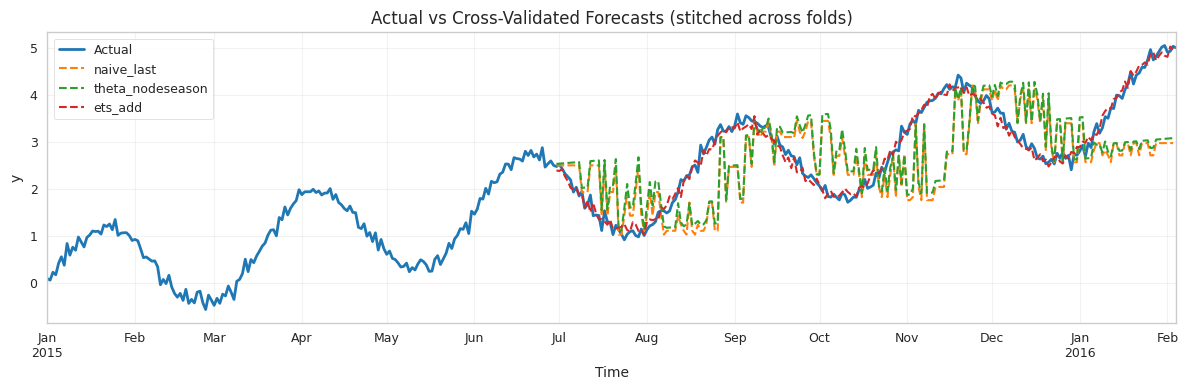

In [66]:
# -----------------------------
# Plots

# 1) Actual vs stitched CV forecasts
fig, ax = plt.subplots(figsize=(12, 4))
y.plot(ax=ax, label="Actual", linewidth=2)
for name, preds in cv_preds.items():
    preds.plot(ax=ax, linestyle="--", label=name)
ax.set_title("Actual vs Cross-Validated Forecasts (stitched across folds)")
ax.set_xlabel("Time")
ax.set_ylabel("y")
ax.legend()
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()



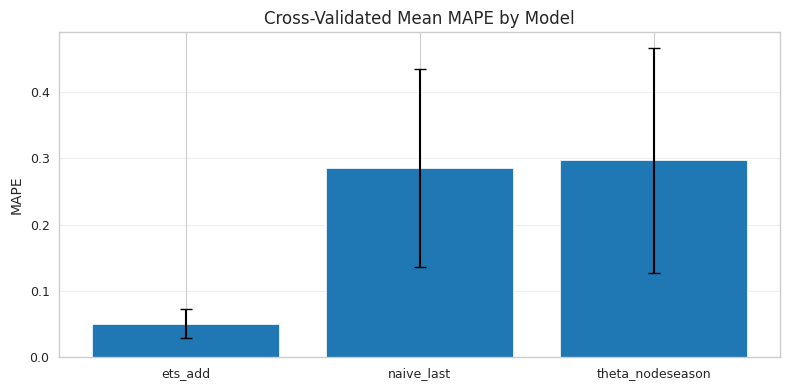

In [67]:
# 2) Mean MAPE by model (with std error bars)
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(results_table))
ax.bar(x, results_table["MAPE_mean"], yerr=results_table["MAPE_std"], capsize=4)
ax.set_xticks(x, results_table["model"])
ax.set_title("Cross-Validated Mean MAPE by Model")
ax.set_ylabel("MAPE")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



In [68]:
# -----------------------------
# Best model by mean MAPE
best_row = results_table.iloc[0]
print({
    "best_model": best_row["model"],
    "best_mape_mean": best_row["MAPE_mean"],
    "best_mape_std": best_row["MAPE_std"],
})


{'best_model': 'ets_add', 'best_mape_mean': np.float64(0.05079799448537462), 'best_mape_std': np.float64(0.021624320334035486)}


# <center></center>
# <center>Have fun!</center>

In [69]:
# !jupyter nbconvert _08-py-wrangling-basics-practice-solutions.ipynb --to html --template classic --output 08-py-wrangling-basics-practice-solutions.html